# Génération des réseaux de formes à partir des règles
- Gén-1 : génération des formes à partir de l'échantillon lexical
- Gén-2 : génération du réseau orienté à partir de Gén-1
- Filt-1 : extraction du sous-réseau symétrique
- Filt-2 : génération du réseau non-orienté correspondant à Filt-1
- Filt-3 : extraction des cliques maximales


## Importations
- codecs pour les encodages
- pandas et numpy pour les calculs sur tableaux
- matplotlib pour les graphiques
- itertools pour les itérateurs sophistiqués (paires sur liste, ...)

In [347]:
# -*- coding: utf8 -*-
import codecs,operator
import features
import re
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import itertools as it
import pickle
import networkx as nx
#%pylab inline
#pd.options.display.mpl_style = 'default'
debug=False
from __future__ import print_function

In [348]:
%matplotlib inline

In [349]:
import yaml

In [350]:
from ipywidgets import FloatProgress
from IPython.display import display, HTML

In [351]:
import datetime
def dateheure():
    return datetime.datetime.utcnow().strftime('%y%m%d%H%M')

In [352]:
saut="\n"

### Préparation des matrices de traits

In [353]:
features.add_config('bdlexique.ini')
fs=features.FeatureSystem('phonemes')

# Choix de l'échantillon et des règles
- *sampleFile* est le nom de l'échantillon de départ
- *analysisPrefix* est une partie du nom des règles

In [354]:
goldPrefix="/Users/gilles/Box Sync/2015-Data"
goldFile="MGC-160104-Verbes2.pkl"
filePrefix="/Volumes/gilles/Transfert/Copies-iMac-GB/2015-Data/MGC-170430"
sampleNumber="19-20000Ko"
sampleType="S"
casesType="-Morphomes"
paperPrefix="-ISMo"
genFormeVotes=True
genCliques=True
listeFormesOutput=["FS","FP"]
genDigraphe=False
genGraphe=False
plotDistributionCliques=False
samplePrefix=filePrefix+"-%s-%s"%(sampleNumber,sampleType)+casesType
sampleFile=samplePrefix+"-paradigmes.csv"
analysisPrefix=samplePrefix
logfile_name=analysisPrefix+"-network.log"
logfile = codecs.open(logfile_name,mode='w',encoding="utf8")

In [355]:
tirage=filePrefix+'-'+sampleNumber+'-Tirage-'+sampleType+'-170503-1927'+casesType+'.pkl'
with open(tirage, 'rb') as input:
    sampleTirage = pickle.load(input)

In [356]:
morphomeCases=sampleTirage[["case","morphome"]].drop_duplicates().to_dict()
casesMC=morphomeCases["case"]
morphomesMC=morphomeCases["morphome"]
dictMorphomeCases={}
for element in casesMC:
    dictMorphomeCases[casesMC[element]]=morphomesMC[element].split("/")
dictMorphomeCases

{u'ai1P': [u'ai1P'],
 u'ai1S': [u'ai1S'],
 u'ai2P': [u'ai2P'],
 u'ai2S': [u'ai2S', u'ai3S', u'is3S'],
 u'ai3P': [u'ai3P'],
 u'fi1P': [u'fi1P', u'fi3P'],
 u'fi1S': [u'fi1S', u'pc2S'],
 u'fi2P': [u'fi2P', u'pc1S', u'pc3P', u'pc3S'],
 u'fi2S': [u'fi2S', u'fi3S'],
 u'ii1P': [u'ii1P'],
 u'ii1S': [u'ii1S', u'ii2S', u'ii3P', u'ii3S'],
 u'ii2P': [u'ii2P'],
 u'inf': [u'inf'],
 u'is1P': [u'is1P'],
 u'is1S': [u'is1S', u'is2S', u'is3P'],
 u'is2P': [u'is2P'],
 u'pI1P': [u'pI1P'],
 u'pI2P': [u'pI2P'],
 u'pI2S': [u'pI2S'],
 u'pP': [u'pP'],
 u'pc1P': [u'pc1P'],
 u'pc2P': [u'pc2P'],
 u'pi1P': [u'pi1P'],
 u'pi1S': [u'pi1S'],
 u'pi2P': [u'pi2P'],
 u'pi2S': [u'pi2S'],
 u'pi3P': [u'pi3P'],
 u'pi3S': [u'pi3S'],
 u'ppFP': [u'ppFP', u'ppFS'],
 u'ppMP': [u'ppMP', u'ppMS'],
 u'ps1P': [u'ps1P'],
 u'ps1S': [u'ps1S', u'ps2S', u'ps3P', u'ps3S'],
 u'ps2P': [u'ps2P']}

### Préparation des cases du paradigme

# Préparation du calcul des analogies

### Calcul de la différence entre deux formes

In [357]:
def diff(mot1,mot2):
    result=[]
    diff1=""
    diff2=""
    same=""
    vide="."
    lmax=max(len(mot1),len(mot2))
    lmin=min(len(mot1),len(mot2))
    for index in range(lmax):
        if index < lmin:
            if mot1[index]!=mot2[index]:
                diff1+=mot1[index]
                diff2+=mot2[index]
                same+=vide
            else:
                same+=mot1[index]
                diff1+=vide
                diff2+=vide
        elif index < len(mot1):
            diff1+=mot1[index]
        elif index < len(mot2):
            diff2+=mot2[index]
    diff1=diff1.lstrip(".")
    diff2=diff2.lstrip(".")
#    return (same,diff1,diff2,diff1+"_"+diff2)
    return (diff1+"-"+diff2)

### Accumulation des paires appartenant à un patron

In [358]:
def rowDiff(row, patrons):
    result=diff(row[0],row[1])
    if not result in patrons:
        patrons[result]=(formesPatron(),formesPatron())
    patrons[result][0].ajouterFormes(row[0])
    patrons[result][1].ajouterFormes(row[1])
    return (result[0],result[1])

### Transformation d'un patron en RegExp

In [359]:
def patron2regexp(morceaux):
    result="^"
    for morceau in morceaux:
        if morceau=="*":
            result+="(.*)"
        elif len(morceau)>1:
            result+="(["+morceau+"])"
        else:
            result+=morceau
    result+="$"
    result=result.replace(")(","")
    return result

### Substitution de sortie 
???

In [360]:
def remplacementSortie(sortie):
    n=1
    nsortie=""
    for lettre in sortie:
        if lettre==".":
            nsortie+="\g<%d>"%n
            n+=1
        else:
            nsortie+=lettre
    return nsortie

# Classe pour la gestion des patrons, des classes et des transformations

In [361]:
class paireClasses:
    def __init__(self,case1,case2):
        self.case1=case1
        self.case2=case2
        self.nom=case1+"-"+case2
        self.classes1=classesPaire(case1,case2)
        self.classes2=classesPaire(case2,case1)

    def ajouterPatron(self,n,patron,motif):
        if n==1:
            self.classes1.ajouterPatron(patron,motif)
        elif n==2:
            self.classes2.ajouterPatron(patron,motif)
        else:
            print ("le numéro de forme n'est pas dans [1,2]",n, file=logfile)

    def ajouterPaire(self,forme1,forme2):
        self.classes1.ajouterPaire(forme1,forme2)
        self.classes2.ajouterPaire(forme2,forme1)
        
    def calculerClasses(self):
        return(self.classes1,self.classes2)

    
class classesPaire:
    '''
    Gestion des patrons, des classes et des transformations
    
    ajouterPatron : ajoute un patron et son motif associé (MGL)
    ajouterPaire : ajoute une paire de formes, calcule la classe de la forme1 et la règle sélectionnée
    sortirForme : cacule les formes de sortie correspondant à la forme1 avec leurs coefficients respectifs
    '''
    def __init__(self,case1,case2):
        self.case1=case1
        self.case2=case2
        self.nom=case1+"-"+case2
        self.classe={}
        self.nbClasse={}
        self.patrons={}
        self.entree={}
        self.sortie={}
        self.classeCF={}
        self.nbClasseCF={}
    
    def ajouterPatron(self,patron,motif):
        self.patrons[patron]=motif
        (entree,sortie)=patron.split("-")
        self.entree[patron]=entree.replace(u".",u"(.)")
        self.sortie[patron]=remplacementSortie(sortie)
    
    def ajouterPaire(self,forme1,forme2):
        '''
        on calcule la classe de la paire idClasseForme et la règle sélectionnée
        on incrémente le compteur de la classe et celui de la règle sélectionnée à l'intérieur de la classe
        '''
        classeFormeCF=[]
        regleFormeCF=""
        classeForme=[]
        regleForme=""
        for patron in self.patrons:
            filterF1=".*"+patron.split("-")[0]+"$"
            if re.match(filterF1,forme1):
                classeFormeCF.append(patron)
                if forme2==re.sub(self.entree[patron]+"$",self.sortie[patron],forme1):
                    regleFormeCF=patron
            filterF1=self.patrons[patron]
            if re.match(filterF1,forme1):
                classeForme.append(patron)
                '''
                le +"$" permet de forcer l'alignement à droite pour les transformations suffixales
                '''
                if forme2==re.sub(self.entree[patron]+"$",self.sortie[patron],forme1):
                    regleForme=patron
        idClasseFormeCF=", ".join(classeFormeCF)
        if not idClasseFormeCF in self.classeCF:
            self.classeCF[idClasseFormeCF]={}
            self.nbClasseCF[idClasseFormeCF]=0
        if not regleFormeCF in self.classeCF[idClasseFormeCF]:
            self.classeCF[idClasseFormeCF][regleFormeCF]=0
        self.nbClasseCF[idClasseFormeCF]+=1
        self.classeCF[idClasseFormeCF][regleFormeCF]+=1
        
        idClasseForme=", ".join(classeForme)
        if not idClasseForme in self.classe:
            self.classe[idClasseForme]={}
            self.nbClasse[idClasseForme]=0
        if not regleForme in self.classe[idClasseForme]:
            self.classe[idClasseForme][regleForme]=0
        self.nbClasse[idClasseForme]+=1
        self.classe[idClasseForme][regleForme]+=1

    def sortirForme(self,forme,contextFree=True):
        classeForme=[]
        sortieForme={}
        for patron in self.patrons:
            if contextFree:
                filterF1=".*"+patron.split("-")[0]+"$"
            else:
                filterF1=self.patrons[patron]
            if re.match(filterF1,forme):
                classeForme.append(patron)
        if classeForme:
            idClasseForme=", ".join(classeForme)
            if contextFree:
                nbClasse=self.nbClasseCF
                classe=self.classeCF
            else:
                nbClasse=self.nbClasse
                classe=self.classe
            if idClasseForme in nbClasse:
                nTotal=nbClasse[idClasseForme]
                for patron in classe[idClasseForme]:
                    sortie=re.sub(self.entree[patron]+"$",self.sortie[patron],forme)
                    sortieForme[sortie]=float(classe[idClasseForme][patron])/nTotal
            else:
                print (forme, file=logfile)
                print ("pas de classe",idClasseForme, file=logfile)
                print ("%.2f par forme de sortie" % (float(1)/len(classeForme)), file=logfile)
                nTotal=len(classeForme)
                for patron in classeForme:
                    sortie=re.sub(self.entree[patron]+"$",self.sortie[patron],forme)
                    sortieForme[sortie]=float(1)/nTotal
        else:
            print (forme, file=logfile) 
            print ("pas de patron", file=logfile)
        return sortieForme
        

## Appliquer la formule de calcul des différences entre chaines à chaque ligne

>si il y a au moins une ligne

>>on applique la différence à la ligne

>>on calcule les deux patrons par suppression des points initiaux

>>on renvoie le groupement par patrons (1&2)

>sinon

>>on renvoie le paradigme vide d'origine

In [362]:
def rapports(paradigme):
    if len(paradigme.columns.values.tolist())==2:
        (case1,lexeme)= paradigme.columns.values.tolist()
        case2=case1
    else:
        (case1,case2,lexeme)= paradigme.columns.values.tolist()
    patrons=pairePatrons(case1,case2)
    classes=paireClasses(case1,case2)
    if len(paradigme)>0:
        paradigme.apply(lambda x: patrons.ajouterFormes(x[case1],x[case2],diff(x[case1],x[case2])), axis=1)
        (regles1,regles2)=patrons.calculerGM()
        for regle in regles1:
            classes.ajouterPatron(1,regle,regles1[regle])
        for regle in regles2:
            classes.ajouterPatron(2,regle,regles2[regle])
        paradigme.apply(lambda x: classes.ajouterPaire(x[case1],x[case2]), axis=1)
    (classes1,classes2)=classes.calculerClasses()
    return (classes1,classes2)

### Dédoubler les lignes avec des surabondances dans *colonne*
>identifier une ligne avec surabondance

>>ajouter les lignes correspondant à chaque valeur

>>ajouter le numéro de la ligne initiale dans les lignes à supprimer

>supprimer les lignes avec surabondance

NB : il faut préparer le tableau pour avoir une indexation qui permette l'ajout des valeurs individuelles et la suppression des lignes de surabondances

In [363]:
def splitCellMates(df,colonne):
    '''
    Calcul d'une dataframe sans surabondance par dédoublement des valeurs
    '''
    test=df.reset_index()
    del test["index"]
    splitIndexes=[]
    for index,ligne in test.iterrows():
        if "," in ligne[colonne]:
            valeurs=set(ligne[colonne].split(","))
            nouvelleLigne=ligne
            for valeur in valeurs:
                nouvelleLigne[colonne]=valeur
                test=test.append(nouvelleLigne,ignore_index=True)
            splitIndexes.append(index)
    if splitIndexes:
        test=test.drop(test.index[splitIndexes])
    return test


# Lecture de l'échantillon

In [364]:
paradigmes=pd.read_csv(sampleFile,sep=";",encoding="utf8")
del paradigmes[u"Unnamed: 0"]
paradigmes=paradigmes.dropna(axis=1,how='all')

In [365]:
#paradigmes

In [366]:
phonologicalMap=sampleType
if debug: print(phonologicalMap)
neutralisationsNORD=(u"6û",u"9ê")
neutralisationsSUD=(u"e2o",u"E9O")
if phonologicalMap=="N":
    neutralisations=neutralisationsNORD
elif phonologicalMap=="S":
    neutralisations=neutralisationsSUD
else:
    neutralisations=(u"",u"")
    phonologicalMap=("X")
bdlexiqueIn = unicode(u"èò"+neutralisations[0])
bdlexiqueNum = [ord(char) for char in bdlexiqueIn]
neutreOut = unicode(u"EO"+neutralisations[1])
neutralise = dict(zip(bdlexiqueNum, neutreOut))

In [367]:
def recoder(chaine,table=neutralise):
    if type(chaine)==str:
        temp=unicode(chaine.decode('utf8')).translate(table)
        result=temp.encode('utf8')
    elif type(chaine)==unicode:
        result=chaine.translate(table)
    else:
        result=chaine
    return result

### Vérification de la phonotactique des glides du français
- si *prononciation* est *None* renvoyer *None*
- ajout de diérèses dans les séquences mal-formées
- vérification des séquences consonne+glide à la finale

In [368]:
dierese={"j":"ij", "w":"uw","H":"yH","i":"ij","u":"uw","y":"yH"}

In [369]:
def checkFrench(prononciation):
    if prononciation:
        result=recoder(prononciation)
        m=re.match(ur"^.*([^ieèEaOouy926êôâ])[jwH]$",result)
        if m:
            print ("pb avec un glide final", prononciation)
        m=re.match(ur"(.*[ptkbdgfsSvzZ][rl])([jwH])(.*)",result)
        if m:
            n=re.search(ur"[ptkbdgfsSvzZ][rl](wa|Hi|wê)",result)
            if not n:
                glide=m.group(2)
                result=m.group(1)+dierese[glide]+m.group(3)
        m=re.match(ur"(.*)([iuy])([ieEaOouy].*)",result)
        if m:
            glide=m.group(2)
            result=m.group(1)+dierese[glide]+m.group(3)
        result=result.replace("Jj","J")
    else:
        result=prononciation
    return result

In [370]:
goldCases=paradigmes.columns.tolist()
goldCases.remove("lexeme")
#goldCases

- sampleCases pour la liste des cases effectivement représentées dans le corpus de départ 

In [371]:
sampleCases=paradigmes.columns.values.tolist()
sampleCases.remove(u"lexeme")
#sampleCases

In [372]:
paradigmes.stack().value_counts(dropna=True).sum()

59969

In [373]:
len(paradigmes.dropna(thresh=1)["lexeme"])

5312

# Lecture des règles

In [374]:
with open(analysisPrefix+'-Regles.pkl', 'rb') as input:
    resultatsLecture = pickle.load(input)

### Comparer les cases analysées avec l'ensemble de toutes les cases

In [375]:
analyseCases=list(set([case for (case,autre) in resultatsLecture.keys()]))
if sorted(analyseCases)!=sorted(goldCases):
    print ("Attention l'analyse ne comprend pas toutes les cases")
    print (sorted(analyseCases))
    print (sorted(goldCases))

# Préparations pour la génération des formes

In [376]:
class paradigmeDistribution:
    '''
    Gestion des distributions dans les cases du paradigme
    '''

    def __init__(self,lexeme):
        self.lexeme=lexeme
        self.formes={i:{} for i in analyseCases}

    def ajouterFormes(self,case,formes,coef=1.0):
        for forme in formes:
            if not forme in self.formes[case]:
                self.formes[case][forme]=0
            self.formes[case][forme]+=formes[forme]*coef
            
    def normaliserDistributions(self,caseListe=analyseCases):
        normalesDistributions={i:{} for i in caseListe}
        for case in caseListe:
            total=0
            for element in self.formes[case]:
                total+=self.formes[case][element]
            for element in self.formes[case]:
                normalesDistributions[case][element]=float(self.formes[case][element])/total
        return normalesDistributions
        

In [377]:
def generateForms(lexeme,contextFree=False):
    candidats=paradigmeDistribution(lexeme)
    casesSamples=paradigmes[paradigmes["lexeme"]==lexeme].columns[paradigmes[paradigmes["lexeme"]==lexeme].notnull().iloc[0]].tolist()
    casesSamples.remove("lexeme")
    for caseDepart in casesSamples:
        formeDepart=paradigmes[paradigmes["lexeme"]==lexeme][caseDepart].iloc[0]
        if debug: print (caseDepart,formeDepart, file=logfile)
#        if formeDepart!="nan":
        for case in analyseCases:
            if debug: print (case, file=logfile)
            if not isinstance(resultatsLecture[(caseDepart, case)],str):
                if "," in formeDepart:
                    formesDepart=formeDepart.split(",")
                    coef=1.0/len(formesDepart)
                    for element in formesDepart:
                        candidats.ajouterFormes(case,resultatsLecture[(caseDepart, case)].sortirForme(element,contextFree),coef)
                else:
                    candidats.ajouterFormes(case,resultatsLecture[(caseDepart, case)].sortirForme(formeDepart,contextFree))
            else: 
                if debug: print ("str", resultatsLecture[(caseDepart, case)], file=logfile)
    return candidats

In [378]:
def ajouterPoint(lexeme,forme,case,digraphe,graphe):
    pointName="%s-%s-%s"%(lexeme,forme,case)
#    if not pointName in digraphe.nodes():
    tam=case[:2]
    if tam=="in": tam="inf"
    digraphe.add_node(pointName, tam='"%s"'%tam)
    graphe.add_node(pointName, tam='"%s"'%tam)
    return pointName

def ajouterFleche(pointDepart,pointSortie,coef,digraphe,graphe):
    digraphe.add_edge(pointDepart,pointSortie,weight=float(coef))
    if digraphe.has_edge(pointSortie,pointDepart):
        coefGraphe=float(digraphe.edge[pointSortie][pointDepart]["weight"]+coef)/2
        graphe.add_edge(pointDepart,pointSortie,weight=coefGraphe)

In [379]:
def generateParadigms(generation1,genDigraphe=True,contextFree=False):
    lexeme=generation1.lexeme
    distributionInitiale=generation1.normaliserDistributions()
    candidats=paradigmeDistribution(lexeme)
    digraphe=nx.DiGraph()
    graphe=nx.Graph()    
    for caseDepart in analyseCases:
        for formeDepart in distributionInitiale[caseDepart]:
            if formeDepart:
                pointDepart=ajouterPoint(lexeme,formeDepart,caseDepart,digraphe,graphe)
                coefDepart=distributionInitiale[caseDepart][formeDepart]
                if debug: print (caseDepart,formeDepart, file=logfile)
                for caseSortie in analyseCases:
                    distributionSortieBrute=resultatsLecture[(caseDepart, caseSortie)].sortirForme(formeDepart,contextFree)
                    if distributionSortieBrute:
                        if not genDigraphe:
#                            print ("brute",distributionSortieBrute)
                            distributionSortie={f:distributionSortieBrute[f] for f in distributionSortieBrute if f in distributionInitiale[caseSortie]}
                        else:
                            distributionSortie=distributionSortieBrute
#                        print ("filtre",distributionSortie)
#                        print (distributionInitiale[caseSortie])
                        if debug: print (caseSortie,distributionSortie,distributionInitiale[caseDepart], file=logfile)
                        candidats.ajouterFormes(caseSortie,distributionSortie,distributionInitiale[caseDepart][formeDepart])
                        for formeSortie in distributionSortie:
                            pointSortie=ajouterPoint(lexeme,formeSortie,caseSortie,digraphe,graphe)
                            coefSortie=distributionSortie[formeSortie]
                            ajouterFleche(pointDepart,pointSortie,float(coefDepart*coefSortie),digraphe,graphe)
    return (candidats,digraphe,graphe)

# Génération d'un jeu de cliques

In [380]:
def generate(lexeme,genDigraphe=True,contextFree=False):
#    print (lexeme,end=", ")
    generation1=generateForms(lexeme,contextFree)
#    print ("génération 2",end=", ")
    (generation2,lexDigraphe,lexGraphe)=generateParadigms(generation1,genDigraphe,contextFree)
    lexCliques=list(nx.algorithms.clique.find_cliques(lexGraphe))
#    print (lexCliques)
#    print ("génération 3")
    return (generation2,lexDigraphe,lexGraphe,lexCliques)

In [381]:
paradigmes.dropna(thresh=1).count().sum()-paradigmes.dropna(thresh=1)["lexeme"].count()

54657

#### Calculer le score de la clique

In [382]:
def cliqueScore(clique,graph):
    score=0
    if len(clique)>1:
        for (depart,arrivee) in it.combinations_with_replacement(clique,2):
            score+=graph[depart][arrivee]["weight"]
    return score

In [383]:
def splitArrivee(arrivee):
    arriveeMorceaux=arrivee.split("-")
    if len(arriveeMorceaux)<3:
        print (arrivee,arriveeMorceaux)
    lexeme="-".join(arriveeMorceaux[:-2])
    formeArrivee=arriveeMorceaux[-2]
    caseArrivee=arriveeMorceaux[-1]
    return (lexeme,formeArrivee,caseArrivee)
    
# trouver tous les liens vers FS-* et FP-*
# regrouper par forme 
# calculer les proportions
# renvoyer les proportions par forme
# avec le nombre de forme à l'appui
def formeScore(forme,graph):
    scores={}
    scoresNormes={}
    for depart in graph.edge:
        for arrivee in graph.edge[depart]:
            (lexeme, formeArrivee, caseArrivee)=splitArrivee(arrivee)
            if caseArrivee==forme:
#                print (depart, formeArrivee, graph.edge[depart][arrivee])
                if not formeArrivee in scores:
                    scores[formeArrivee]=0
                scores[formeArrivee]+=graph.edge[depart][arrivee]["weight"]
    totalArrivee=0
    for formeArrivee in scores:
        totalArrivee+=scores[formeArrivee]
    for formeArrivee in scores:
        scoresNormes[formeArrivee]=scores[formeArrivee]/totalArrivee
    return (scores,scoresNormes)
        

## Préparations pour SWIM

In [384]:
#%%time
debug=False
listeTest=paradigmes.dropna(thresh=1)["lexeme"].values.tolist()
'''
listeTest=[u"abouler", u"abroger", u"admonester", u"aguicher", u"ajourer", u"ankyloser", u"antidater", 
           u"architecturer", u"argenter", u"arraisonner", u"asphalter", u"assermenter", u"autopsier", 
           u"banquer", u"biberonner", u"biner", u"bossuer", u"botteler", u"boucaner", u"bourlinguer", 
           u"braiser", u"brasiller", u"brigander", u"brimbaler", u"brinquebaler", u"brocarder", u"buriner", 
           u"bétonner", u"bêtifier", u"cadencer", u"canoniser", u"canonner", u"canoter", u"caparaçonner", 
           u"capitaliser", u"capitonner", u"caricaturer", u"carminer", u"carreler", u"cauchemarder", 
           u"cautériser", u"chaperonner", u"chapitrer", u"charpenter", u"chatoyer", u"chauler", 
           u"circonvenir", u"clamser", u"clapper", u"classifier", u"colleter", u"congestionner", 
           u"criailler", u"crotter", u"croustiller", u"crépir", u"cuivrer", u"daller", u"dessiller", 
           u"discutailler", u"débaptiser", u"déblatérer", u"déboussoler", u"débouter", u"débraguetter", 
           u"débroussailler", u"décalotter", u"décapuchonner", u"déclasser", u"déclouer", u"dédire", 
           u"défalquer", u"défavoriser", u"défraîchir", u"défroquer", u"démunir", u"démâter", u"déniaiser", 
           u"dépeigner", u"déplisser", u"dépolir", u"déposséder", u"dépraver", u"dépressuriser", u"désappointer", 
           u"désavantager", u"désemparer", u"désenfler", u"désengager", u"désennuyer", u"emberlificoter", 
           u"empailler", u"emperler", u"empierrer", u"emplumer", u"encarter", u"enchérir", u"encoder", 
           u"encoller", u"endiabler", u"endimancher", u"endoctriner", u"engouer", u"engrener", u"enneiger", 
           u"enrubanner", u"ensoleiller", u"entr'apercevoir", u"entre-déchirer", u"entre-dévorer", 
           u"entre-regarder", u"essaimer", u"estampiller", u"estoquer", u"expectorer", u"fabuler", u"fanatiser", 
           u"fauter", u"fermenter", u"festonner", u"flemmarder", u"fourgonner", u"fragiliser", u"fricasser", 
           u"frigorifier", u"fronder", u"galber", u"galonner", u"gauchir", u"gaufrer", u"givrer", u"godiller", 
           u"grasseyer", u"grener", u"grillager", u"gréer", u"grêler", u"gîter", u"habiliter", u"hospitaliser", 
           u"hâler", u"ignifuger", u"imager", u"initialiser", u"interloquer", u"invalider", u"jargonner", 
           u"jasper", u"javelliser", u"juter", u"lanterner", u"ligner", u"limoger", u"lister", u"magnétiser", 
           u"mailler", u"majorer", u"manucurer", u"manufacturer", u"marginaliser", u"marqueter", u"matelasser", 
           u"materner", u"mazer", u"meuler", u"mitiger", u"morfaler", u"mystifier", u"métisser", u"métrer", 
           u"officialiser", u"orthographier", u"ouater", u"oxyder", u"pager", u"palmer", u"panner", u"passiver", 
           u"pelleter", u"piqueter", u"plastiquer", u"polycopier", u"ponctionner", u"ponter", u"portraiturer", 
           u"préfacer", u"présupposer", u"pâturer", u"pérégriner", u"raciner", u"ragoter", u"randonner", 
           u"rapetasser", u"rapiécer", u"ratiboiser", u"rationaliser", u"rebaisser", u"recasser", u"recrépir", 
           u"rediffuser", u"regarnir", u"reloger", u"remailler", u"remarcher", u"remblayer", u"remplier", 
           u"renfler", u"rependre", u"ressemeler", u"retranscrire", u"retremper", u"retéléphoner", u"revaloir", 
           u"revancher", u"revivifier", u"ripailler", u"ripoliner", u"réadapter", u"réembaucher", u"réengager", 
           u"réfracter", u"réfrigérer", u"réguler", u"réhabituer", u"réinviter", u"répertorier", u"rééduquer", 
           u"rééquilibrer", u"sabouler", u"saccader", u"salarier", u"saloper", u"satiner", u"schématiser", 
           u"sevrer", u"singulariser", u"socialiser", u"sonoriser", u"souquer", u"sourciller", u"spiritualiser", 
           u"surajouter", u"surfaire", u"surgeler", u"suturer", u"talquer", u"tarer", u"tournebouler", u"transmuer", 
           u"triquer", u"truster", u"tuméfier", u"valdinguer", u"vaticiner", u"veiner", u"verbaliser", u"verdoyer", 
           u"vilipender", u"vinaigrer", u"viner", u"violacer", u"vitupérer", u"zipper", u"zozoter", u"écrouer", 
           u"édulcorer", u"émacier", u"épeurer", u"épiloguer", u"équarrir", u"érotiser", u"étriquer", u"étrécir", 
           u"évangéliser"]
listeTest=[u"corriger",u"résulter",u"émerger",u"injecter","concevoir","collaborer",u"coopérer",u"méditer"]
listeTest=[u"attiédir", u"blettir", u"bouffir", u"bruire", u"candir", u"clapir", u"coproduire", u"dessertir", u"défleurir", u"dégrossir", u"détordre", u"dévernir", u"enceindre", u"enclore", u"entrapercevoir", u"froidir", u"matir", u"mincir", u"raire", u"rapprendre", u"rechampir", u"refendre", u"reteindre", u"retraduire", u"roustir", u"réassortir", u"réinscrire", u"sourdre", u"surir", u"émoudre"]
#listeTest=[u"dégrossir",u"crépir"]
'''
#listeTest=[u"asseoir",u"balayer",u"manger"]
#verbeTest=listeTest[0]
nbVerbes=len(listeTest)
print (nbVerbes)

5312


In [385]:
def generateAnalysis(globDigraphe,globGraphe,contextFree=False):
    numClique=0
    progressBar = FloatProgress(min=0, max=nbVerbes-1)
    display(progressBar)
    for i,element in enumerate(listeTest):
        cliquesScores[element]={}
        cliquesListes[element]={}
    #    if (i%100)==0: print (i, dateheure()[-4:], int(100*float(i)/nbVerbes), end=", ")
        progressBar.value=i
        #print (element)
        result=generate(element,genDigraphe,contextFree)
        (generation,lexDigraphe,lexGraphe,lexCliques)= result
    #    print (generation,lexDigraphe,lexGraphe,lexCliques)
        if genFormeVotes:
            formesScores[element]={}
            formesScoresNormes[element]={}
            for formeOutput in listeFormesOutput:
                (formesScores[element][formeOutput],formesScoresNormes[element][formeOutput])=formeScore(formeOutput,lexDigraphe)
        if genDigraphe:
            globDigraphe=nx.union(globDigraphe,lexDigraphe)
        if genGraphe:
            globGraphe=nx.union(globGraphe,lexGraphe)
        cliques.extend(lexCliques)
        for clique in lexCliques:
            cliquesScores[element][numClique]=cliqueScore(clique,lexGraphe)
            cliquesListes[element][numClique]=clique
            numClique+=1
    return globDigraphe,globGraphe,numClique

In [386]:
def dictCliqueForms(clique):
    result={}
    for element in clique:
        lexeme,forme,case=splitArrivee(element)
        for c in dictMorphomeCases[case]:
            result[c]=forme
    return result

def dictPdRowForms(row):
    result={}
    for case in sampleCases:
        print (case,row[case].values[0])
    return result

def tableZero(case):
    if case in sampleCases:
        return u"Ø"
    else:
        return u"="

def makeTable(dictForms,title=""):
    tabular=[]
    labelTenseCode={"pi":"Present","ii":"Imperfective","ai":"Simple Past","fi":"Future",
                    "ps":"Subjunctive Pres.","is":"Subjunctive Imp.","pc":"Conditional","pI":"Imperative",
                    "inf":"Infinitive",
                    "ppMS":"Past Part. MS","ppMP":"Past Part. MP",
                    "ppFS":"Past Part. FS","ppMP":"Past Part. FP"
                   }
    def makeLine6(tenseCode):
        line=[]
        line.append(r"<th>%s</th>"%labelTenseCode[tenseCode])
        for person in [per+nb for nb in ["S","P"] for per in ["1","2","3"]]:
            case=tenseCode+person
            if (case in dictForms) and (not (type(dictForms[case]) == float and np.isnan(dictForms[case]))):
                line.append(r"<td>%s</td>"%(dictForms[case]))
            else:
                line.append(r"<td>%s</td>"%(tableZero(case)))
        return r"<tr>"+r"".join(line)+r"</tr>"

    def makeLine3(tenseCode):
        line=[]
        line.append(r"<th>%s</th>"%labelTenseCode[tenseCode])
        for person in [per+nb for nb in ["S","P"] for per in ["1","2","3"]]:
            if person in ["2S","1P","2P"]:
                case=tenseCode+person
                if case in dictForms and (not (type(dictForms[case]) == float and np.isnan(dictForms[case]))):
                    line.append(r"<td>%s</td>"%(dictForms[case]))
                else:
                    line.append(r"<td>%s</td>"%(tableZero(case)))
            else:
                line.append(r"<td>%s</td>"%(u"---"))
        return r"<tr>"+r"".join(line)+r"</tr>"
    
    def makeLineNF():
        line=[]
        line.append(r"<th>%s</th>"%"NF")
        for case in ["inf","pP","ppMS","ppMP","ppFS","ppFP"]:
            if case in dictForms and (not (type(dictForms[case]) == float and np.isnan(dictForms[case]))):
                line.append(r"<td>%s</td>"%(dictForms[case]))
            else:
                line.append(r"<td>%s</td>"%(tableZero(case)))
        return r"<tr>"+r"".join(line)+r"</tr>"
    
        
    top=[
        r"<table>",
        r"<caption style='caption-side:bottom;text-align:center'>",
        "Verbe : %s"%title,
        r"</caption>",
#        r"<tr><th/><th>1S</th><th>2S</th><th>3S</th><th>1P</th><th>2P</th><th>3P</th></tr>"
        r"<tr><th/><th>1SG</th><th>2SG</th><th>3SG</th><th>1PL</th><th>2PL</th><th>3PL</th></tr>"
        ]
    bottom=[
        r"</table>"
        ]
    tabular.append("\n".join(top))
    for tenseCode in ["pi","ii","fi","pc", "ps","ai", "is"]:
        tabular.append(makeLine6(tenseCode))
    tabular.append(makeLine3("pI"))
    tabular.append(makeLineNF())
    tabular.append("\n".join(bottom))
    return "\n".join(tabular)    

def diffParadigme(lexeme):
    outLen=lexemeMaxCliques[lexeme][0]
    inLen=paradigmes[paradigmes["lexeme"]==lexeme].notnull().sum(axis=1).values[0]-1
    if outLen>inLen:
        print (lexemeMaxCliques[lexeme][1])
        print (paradigmes[paradigmes["lexeme"]=="grandir"].values)
    return outLen-inLen
    

In [387]:
def checkFidelite(fidelite,clique):
    lFidele=False
    for element in clique:
        if fidelite in element:
            lFidele=True
    return lFidele

def generateCliques(contextFree=False):
    
    def bruteCliques(lexeme,maxCliqueSize=51):
        cliquesBrutes={n+1:0 for n in range(maxCliqueSize)}
        for l in cliquesListes[lexeme].values():
            longueur=len(l)
            if longueur>1:
                if not longueur in cliquesBrutes:
                    cliquesBrutes[longueur]=0
                cliquesBrutes[longueur]+=1
        return cliquesBrutes
    
    globDigraphe=nx.DiGraph()
    globGraphe=nx.Graph()

    globDigraphe,globGraphe,numClique=generateAnalysis(globDigraphe,globGraphe,contextFree)
    print 

    lexemeMaxCliques={}
    lexemeParadigmes={}
    for lexeme in cliquesListes:
        maxLen=max([len(c) for c in cliquesListes[lexeme].values()])
        lexemeMaxCliques[lexeme]=bruteCliques(lexeme,maxLen)
        print (lexeme,"Nombre de cliques",sum([v for k,v in lexemeMaxCliques[lexeme].iteritems()]))
        maxNbCliques=max([v for k,v in lexemeMaxCliques[lexeme].iteritems()])
        if plotDistributionCliques:
            ax=pd.DataFrame.from_dict(lexemeMaxCliques[lexeme],orient="index").plot(kind="bar",legend=False,grid=True,figsize=(10,3))
            ax.set(xlim=(0,maxLen+.5),ylim=(0,maxNbCliques+10))
            ax.set_xlabel("Clique Size in Cells",fontsize=16)
            ax.set_ylabel("Number of Cliques",fontsize=16)

        dictParadigmes=paradigmes.set_index("lexeme").to_dict(orient="index")

        cliquesFideles={}
        fidelites=[v+"-"+k for k,v in dictParadigmes[lexeme].iteritems() if isinstance(v,unicode)]
        for l in cliquesListes[lexeme].values():
            longueur=len(l)
            if longueur>1:
                fidele=True
                for fidelite in fidelites:
                    if "," in fidelite:
                        fideliteForme,fideliteCase=fidelite.split("-")
                        fideliteFormes=fideliteForme.split(",")
                        fideliteItems=[fideliteF+"-"+fideliteCase for fideliteF in fideliteFormes]
#                        print (fideliteItems)
                        lFidele=True
                        for f in fideliteItems:
                            lFidele=lFidele & checkFidelite(f,l)
                    else:
                        lFidele=checkFidelite(fidelite,l)
                    if not lFidele:
                        fidele=False
                        break
                if fidele:
                    if not longueur in cliquesFideles:
                        cliquesFideles[longueur]=[]
                    cliquesFideles[longueur].append(l)
#                else:
#                    if lexeme==u"bégayer": print ()
#        print ([(k,len(v)) for k,v in cliquesFideles.iteritems()])
        if cliquesFideles:
            maxCliquesCard=max([k for k,v in cliquesFideles.iteritems()])
    #        print (maxCliquesCard)
    #        print (cliquesScores[lexeme])
    #        print (cliquesListes[lexeme])
            lexemeParadigmes[lexeme]=[]
            maxScoreCliques=max([clique for cliqueNumber, clique in cliquesScores[lexeme].items()])
            maxCardScoreNums=[numC for numC, c in cliquesListes[lexeme].items() if c in cliquesFideles[maxCliquesCard]]
            maxCardScore=max([scoreC for numC, scoreC in cliquesScores[lexeme].items() if numC in maxCardScoreNums])
    #        print ("max score among all cliques:",maxScoreCliques)
            print ("max score among faithfull cliques of %d forms:"%maxCliquesCard,maxCardScore)
            for c in cliquesFideles[maxCliquesCard]:
                cNumber=[cliqueNumber for cliqueNumber, clique in cliquesListes[lexeme].items() if clique == c]
                if len(cNumber)!=1:
                    print ("TOO MANY SCORES PROBLEM WITH CLIQUE", cNumber)
    #            print ("Liste n°",cNumber[0],cliquesScores[lexeme][cNumber[0]])
    #            print (sorted(cliquesScores[lexeme].items(), key=operator.itemgetter(1)))
    #            display(HTML(makeTable(dictCliqueForms(c),title=c[0].split("-")[0])))
    #            print (cliquesScores[lexeme][cNumber[0]], maxCardScore)
                if cliquesScores[lexeme][cNumber[0]]==maxCardScore:
                    lexemeParadigmes[lexeme].append(c)
        else:
            print (u"pas de cliques fidèles")
            lexemeParadigmes[lexeme]=[[lexeme+"-"+f for f in fidelites]]
    return lexemeParadigmes

# SWIM1

In [388]:
cliques=[]
cliquesScores={}
cliquesListes={}

formesScores={}
formesScoresNormes={}

%time contextParadigmes=generateCliques()

escamoter Nombre de cliques 25
max score among faithfull cliques of 30 forms: 443.167611168
anémier Nombre de cliques 11
max score among faithfull cliques of 20 forms: 170.188705184
enquérir Nombre de cliques 102
max score among faithfull cliques of 13 forms: 73.0391152911
réfugier Nombre de cliques 130
max score among faithfull cliques of 21 forms: 153.910302009
assembler Nombre de cliques 22
max score among faithfull cliques of 27 forms: 371.012144851
ensanglanter Nombre de cliques 21
max score among faithfull cliques of 28 forms: 398.280129374
projeter Nombre de cliques 108
max score among faithfull cliques of 27 forms: 234.344829116
sabler Nombre de cliques 22
max score among faithfull cliques of 27 forms: 369.9442248
forger Nombre de cliques 32
max score among faithfull cliques of 29 forms: 419.811342517
féminiser Nombre de cliques 19
max score among faithfull cliques of 30 forms: 443.454890826
aider Nombre de cliques 21
max score among faithfull cliques of 32 forms: 518.033081156

max score among faithfull cliques of 31 forms: 469.026587673
financer Nombre de cliques 33
max score among faithfull cliques of 28 forms: 382.547218338
convulsionner Nombre de cliques 5
max score among faithfull cliques of 30 forms: 457.380424025
incuber Nombre de cliques 13
max score among faithfull cliques of 29 forms: 422.198852147
remplacer Nombre de cliques 28
max score among faithfull cliques of 31 forms: 476.804470761
empâter Nombre de cliques 23
max score among faithfull cliques of 31 forms: 459.473667423
muer Nombre de cliques 25
max score among faithfull cliques of 22 forms: 240.788822597
revouloir Nombre de cliques 108
max score among faithfull cliques of 7 forms: 18.7821688798
enquiquiner Nombre de cliques 17
max score among faithfull cliques of 30 forms: 452.812290788
coter Nombre de cliques 25
max score among faithfull cliques of 30 forms: 442.041806724
biner Nombre de cliques 22
max score among faithfull cliques of 30 forms: 447.578030395
reprocher Nombre de cliques 29
m

max score among faithfull cliques of 25 forms: 260.138458493
convoler Nombre de cliques 9
max score among faithfull cliques of 29 forms: 430.291460744
sortir Nombre de cliques 201
max score among faithfull cliques of 30 forms: 140.712169784
berner Nombre de cliques 17
max score among faithfull cliques of 30 forms: 445.175687994
patoiser Nombre de cliques 2
max score among faithfull cliques of 31 forms: 478.442397505
estimer Nombre de cliques 24
max score among faithfull cliques of 30 forms: 448.332330668
précipiter Nombre de cliques 33
max score among faithfull cliques of 30 forms: 427.11981583
raréfier Nombre de cliques 199
max score among faithfull cliques of 25 forms: 251.407115567
orner Nombre de cliques 14
max score among faithfull cliques of 31 forms: 472.006918066
sous-payer Nombre de cliques 8
max score among faithfull cliques of 38 forms: 357.072282438
cajoler Nombre de cliques 24
max score among faithfull cliques of 29 forms: 429.012749577
déclencher Nombre de cliques 26
max 

bourgeonner Nombre de cliques 13
max score among faithfull cliques of 30 forms: 447.734358037
repincer Nombre de cliques 12
max score among faithfull cliques of 28 forms: 392.718335854
assener Nombre de cliques 89
max score among faithfull cliques of 12 forms: 42.1123839388
rejaillir Nombre de cliques 194
max score among faithfull cliques of 23 forms: 147.195138842
roupiller Nombre de cliques 99
max score among faithfull cliques of 27 forms: 280.522268903
doigter Nombre de cliques 9
max score among faithfull cliques of 31 forms: 479.144026005
dévernir Nombre de cliques 27
max score among faithfull cliques of 22 forms: 188.15823561
accéder Nombre de cliques 59
max score among faithfull cliques of 31 forms: 379.137502717
tarauder Nombre de cliques 32
max score among faithfull cliques of 29 forms: 395.161512402
entrapercevoir Nombre de cliques 29
max score among faithfull cliques of 28 forms: 126.31740118
défiler Nombre de cliques 21
max score among faithfull cliques of 30 forms: 456.9481

tourbillonner Nombre de cliques 10
max score among faithfull cliques of 30 forms: 451.26746401
acheminer Nombre de cliques 17
max score among faithfull cliques of 30 forms: 455.672944803
stabiliser Nombre de cliques 23
max score among faithfull cliques of 30 forms: 420.318140736
diminuer Nombre de cliques 21
max score among faithfull cliques of 25 forms: 313.757304242
mandater Nombre de cliques 23
max score among faithfull cliques of 31 forms: 452.029800064
blinder Nombre de cliques 18
max score among faithfull cliques of 28 forms: 398.994657004
accroire Nombre de cliques 9
max score among faithfull cliques of 22 forms: 224.446030207
électrifier Nombre de cliques 19
max score among faithfull cliques of 24 forms: 248.01193749
emprunter Nombre de cliques 32
max score among faithfull cliques of 28 forms: 380.555343415
présider Nombre de cliques 40
max score among faithfull cliques of 29 forms: 413.58336492
créer Nombre de cliques 174
max score among faithfull cliques of 22 forms: 167.4570

max score among faithfull cliques of 12 forms: 39.0774316678
enfanter Nombre de cliques 26
max score among faithfull cliques of 28 forms: 370.35071865
ramollir Nombre de cliques 67
max score among faithfull cliques of 23 forms: 194.305679503
désaffecter Nombre de cliques 9
max score among faithfull cliques of 28 forms: 402.151265823
étalonner Nombre de cliques 7
max score among faithfull cliques of 30 forms: 461.562487649
empoter Nombre de cliques 10
max score among faithfull cliques of 30 forms: 444.934741088
bavasser Nombre de cliques 65
max score among faithfull cliques of 31 forms: 445.644513021
promener Nombre de cliques 57
max score among faithfull cliques of 27 forms: 261.51021312
construire Nombre de cliques 155
max score among faithfull cliques of 25 forms: 184.333795168
écraser Nombre de cliques 50
max score among faithfull cliques of 31 forms: 456.011814789
octroyer Nombre de cliques 47
max score among faithfull cliques of 24 forms: 193.516863988
tisser Nombre de cliques 83


ramager Nombre de cliques 20
max score among faithfull cliques of 29 forms: 419.178732429
décentrer Nombre de cliques 19
max score among faithfull cliques of 27 forms: 349.575006937
coulisser Nombre de cliques 22
max score among faithfull cliques of 27 forms: 288.461200373
sponsoriser Nombre de cliques 32
max score among faithfull cliques of 30 forms: 440.175480232
herser Nombre de cliques 29
max score among faithfull cliques of 31 forms: 461.3739311
reluquer Nombre de cliques 21
max score among faithfull cliques of 29 forms: 429.151563303
nuer Nombre de cliques 5
max score among faithfull cliques of 25 forms: 318.703667731
embaucher Nombre de cliques 28
max score among faithfull cliques of 29 forms: 420.044308647
caricaturer Nombre de cliques 14
max score among faithfull cliques of 29 forms: 417.968456766
dépraver Nombre de cliques 53
max score among faithfull cliques of 25 forms: 285.896528543
incurver Nombre de cliques 39
max score among faithfull cliques of 31 forms: 465.736609119


river Nombre de cliques 41
max score among faithfull cliques of 29 forms: 386.559887695
enrouer Nombre de cliques 17
max score among faithfull cliques of 24 forms: 279.005924359
pondre Nombre de cliques 49
max score among faithfull cliques of 27 forms: 218.593309302
avouer Nombre de cliques 31
max score among faithfull cliques of 26 forms: 315.190974314
calotter Nombre de cliques 16
max score among faithfull cliques of 30 forms: 457.345559296
bruire Nombre de cliques 97
max score among faithfull cliques of 22 forms: 150.779910139
éberluer Nombre de cliques 21
max score among faithfull cliques of 23 forms: 264.286488582
préluder Nombre de cliques 15
max score among faithfull cliques of 30 forms: 455.02065975
déconstiper Nombre de cliques 4
max score among faithfull cliques of 30 forms: 450.205345568
regreffer Nombre de cliques 42
max score among faithfull cliques of 25 forms: 227.265401163
débrancher Nombre de cliques 34
max score among faithfull cliques of 28 forms: 390.624703886
convu

cafter Nombre de cliques 16
max score among faithfull cliques of 29 forms: 419.314912741
détester Nombre de cliques 23
max score among faithfull cliques of 25 forms: 319.163543569
évaluer Nombre de cliques 33
max score among faithfull cliques of 23 forms: 263.86916659
trotter Nombre de cliques 35
max score among faithfull cliques of 30 forms: 428.415433909
rançonner Nombre de cliques 16
max score among faithfull cliques of 30 forms: 451.52989369
escompter Nombre de cliques 29
max score among faithfull cliques of 28 forms: 385.17066849
embusquer Nombre de cliques 17
max score among faithfull cliques of 28 forms: 403.493440947
programmer Nombre de cliques 19
max score among faithfull cliques of 31 forms: 472.535914879
ranger Nombre de cliques 35
max score among faithfull cliques of 28 forms: 389.389321837
étourdir Nombre de cliques 211
max score among faithfull cliques of 25 forms: 209.985982052
adapter Nombre de cliques 20
max score among faithfull cliques of 28 forms: 399.886784952
sub

max score among faithfull cliques of 29 forms: 429.589870126
paraître Nombre de cliques 189
max score among faithfull cliques of 27 forms: 239.324665863
empêcher Nombre de cliques 34
max score among faithfull cliques of 29 forms: 417.37328675
mentir Nombre de cliques 141
max score among faithfull cliques of 23 forms: 118.908518379
intérioriser Nombre de cliques 33
max score among faithfull cliques of 30 forms: 437.018012033
décomposer Nombre de cliques 50
max score among faithfull cliques of 30 forms: 429.007902205
marginaliser Nombre de cliques 19
max score among faithfull cliques of 30 forms: 419.402243958
jucher Nombre de cliques 27
max score among faithfull cliques of 29 forms: 422.381487035
perdurer Nombre de cliques 19
max score among faithfull cliques of 29 forms: 411.794428265
rassortir Nombre de cliques 24
max score among faithfull cliques of 28 forms: 170.960965157
débloquer Nombre de cliques 22
max score among faithfull cliques of 29 forms: 429.050206366
treillisser Nombre d

max score among faithfull cliques of 31 forms: 452.320643964
chancir Nombre de cliques 17
max score among faithfull cliques of 24 forms: 198.044309634
paralyser Nombre de cliques 27
max score among faithfull cliques of 30 forms: 420.182750125
pétuner Nombre de cliques 11
max score among faithfull cliques of 30 forms: 451.010587895
apurer Nombre de cliques 18
max score among faithfull cliques of 29 forms: 414.86353435
biturer Nombre de cliques 8
max score among faithfull cliques of 29 forms: 422.373811042
pécher Nombre de cliques 22
max score among faithfull cliques of 29 forms: 417.321901112
contenir Nombre de cliques 97
max score among faithfull cliques of 28 forms: 363.679685377
tiédir Nombre de cliques 215
max score among faithfull cliques of 24 forms: 183.63771495
contremander Nombre de cliques 6
max score among faithfull cliques of 28 forms: 393.195881386
rationner Nombre de cliques 7
max score among faithfull cliques of 30 forms: 457.151226493
apaiser Nombre de cliques 77
max sco

fléchir Nombre de cliques 154
max score among faithfull cliques of 24 forms: 225.648971301
bouffonner Nombre de cliques 12
max score among faithfull cliques of 30 forms: 449.289653361
viser Nombre de cliques 105
max score among faithfull cliques of 27 forms: 315.118714098
déliter Nombre de cliques 18
max score among faithfull cliques of 30 forms: 456.410748455
surchauffer Nombre de cliques 61
max score among faithfull cliques of 28 forms: 373.929367441
extirper Nombre de cliques 19
max score among faithfull cliques of 31 forms: 472.045027245
intégrer Nombre de cliques 34
max score among faithfull cliques of 26 forms: 342.2727682
méditer Nombre de cliques 35
max score among faithfull cliques of 30 forms: 428.922409849
proroger Nombre de cliques 13
max score among faithfull cliques of 29 forms: 426.676761755
partouzer Nombre de cliques 36
max score among faithfull cliques of 30 forms: 411.212486006
soutirer Nombre de cliques 23
max score among faithfull cliques of 29 forms: 411.957369835

max score among faithfull cliques of 28 forms: 390.213570652
inspecter Nombre de cliques 20
max score among faithfull cliques of 24 forms: 296.94291514
retordre Nombre de cliques 5
max score among faithfull cliques of 24 forms: 199.250036248
scinder Nombre de cliques 35
max score among faithfull cliques of 28 forms: 377.558747923
embarrer Nombre de cliques 12
max score among faithfull cliques of 26 forms: 332.08179599
tolérer Nombre de cliques 36
max score among faithfull cliques of 30 forms: 431.527327955
politiser Nombre de cliques 16
max score among faithfull cliques of 28 forms: 378.375248273
marauder Nombre de cliques 25
max score among faithfull cliques of 29 forms: 378.806851571
quintupler Nombre de cliques 22
max score among faithfull cliques of 26 forms: 347.928968203
décorer Nombre de cliques 32
max score among faithfull cliques of 29 forms: 396.917508626
connaître Nombre de cliques 88
max score among faithfull cliques of 29 forms: 330.554257934
mignarder Nombre de cliques 16

max score among faithfull cliques of 27 forms: 230.652334503
malmener Nombre de cliques 42
max score among faithfull cliques of 27 forms: 264.706143434
sniffer Nombre de cliques 7
max score among faithfull cliques of 29 forms: 415.46730935
frire Nombre de cliques 114
max score among faithfull cliques of 19 forms: 112.141647057
cravater Nombre de cliques 29
max score among faithfull cliques of 31 forms: 463.369169277
redouter Nombre de cliques 33
max score among faithfull cliques of 30 forms: 429.370403545
réaffûter Nombre de cliques 5
max score among faithfull cliques of 30 forms: 448.683939359
rétorquer Nombre de cliques 32
max score among faithfull cliques of 29 forms: 423.363383629
doter Nombre de cliques 27
max score among faithfull cliques of 30 forms: 437.353420325
disserter Nombre de cliques 30
max score among faithfull cliques of 29 forms: 395.180924091
boitiller Nombre de cliques 91
max score among faithfull cliques of 27 forms: 273.502824152
rabougrir Nombre de cliques 131
ma

max score among faithfull cliques of 30 forms: 454.059783824
hospitaliser Nombre de cliques 12
max score among faithfull cliques of 30 forms: 436.130133029
barguigner Nombre de cliques 6
max score among faithfull cliques of 27 forms: 373.097409835
encenser Nombre de cliques 35
max score among faithfull cliques of 28 forms: 378.542916275
fricoter Nombre de cliques 28
max score among faithfull cliques of 30 forms: 436.948244199
excommunier Nombre de cliques 58
max score among faithfull cliques of 17 forms: 123.340424134
arracher Nombre de cliques 34
max score among faithfull cliques of 29 forms: 418.201189401
flétrir Nombre de cliques 157
max score among faithfull cliques of 19 forms: 129.201702066
prévoir Nombre de cliques 227
max score among faithfull cliques of 18 forms: 89.21677709
soupçonner Nombre de cliques 19
max score among faithfull cliques of 30 forms: 448.35486778
masquer Nombre de cliques 21
max score among faithfull cliques of 28 forms: 402.190275868
entremettre Nombre de c

regretter Nombre de cliques 54
max score among faithfull cliques of 32 forms: 401.6796913
dépersonnaliser Nombre de cliques 4
max score among faithfull cliques of 30 forms: 436.417377368
galonner Nombre de cliques 8
max score among faithfull cliques of 30 forms: 460.709799781
réintégrer Nombre de cliques 60
max score among faithfull cliques of 26 forms: 330.033207509
reparler Nombre de cliques 8
max score among faithfull cliques of 32 forms: 523.480600305
chaumer Nombre de cliques 9
max score among faithfull cliques of 30 forms: 456.207752243
écumer Nombre de cliques 20
max score among faithfull cliques of 30 forms: 452.969915431
diffracter Nombre de cliques 6
max score among faithfull cliques of 28 forms: 401.854808648
adouber Nombre de cliques 11
max score among faithfull cliques of 30 forms: 450.241875302
ragoûter Nombre de cliques 16
max score among faithfull cliques of 30 forms: 424.099484802
soupirer Nombre de cliques 30
max score among faithfull cliques of 29 forms: 408.08736205

humecter Nombre de cliques 15
max score among faithfull cliques of 28 forms: 401.40562257
ajourner Nombre de cliques 7
max score among faithfull cliques of 31 forms: 477.5199399
vaser Nombre de cliques 3
max score among faithfull cliques of 31 forms: 476.13328595
renégocier Nombre de cliques 8
max score among faithfull cliques of 24 forms: 245.512677679
perler Nombre de cliques 17
max score among faithfull cliques of 32 forms: 524.654027422
saupoudrer Nombre de cliques 43
max score among faithfull cliques of 24 forms: 277.183326477
ensevelir Nombre de cliques 72
max score among faithfull cliques of 23 forms: 193.986334534
enchemiser Nombre de cliques 10
max score among faithfull cliques of 30 forms: 451.881699052
uniformiser Nombre de cliques 19
max score among faithfull cliques of 30 forms: 447.1629131
pensionner Nombre de cliques 7
max score among faithfull cliques of 30 forms: 457.019761777
escrimer Nombre de cliques 16
max score among faithfull cliques of 30 forms: 449.892372961
em

emmener Nombre de cliques 56
max score among faithfull cliques of 28 forms: 282.63731829
avoisiner Nombre de cliques 19
max score among faithfull cliques of 30 forms: 445.876009524
encroûter Nombre de cliques 26
max score among faithfull cliques of 30 forms: 440.55617852
décérébrer Nombre de cliques 9
max score among faithfull cliques of 27 forms: 365.073083496
glouglouter Nombre de cliques 12
max score among faithfull cliques of 30 forms: 451.238699315
saucissonner Nombre de cliques 14
max score among faithfull cliques of 30 forms: 453.340009934
intriguer Nombre de cliques 25
max score among faithfull cliques of 28 forms: 391.733465862
pendre Nombre de cliques 67
max score among faithfull cliques of 27 forms: 212.056496165
alléguer Nombre de cliques 19
max score among faithfull cliques of 29 forms: 429.617985361
vénérer Nombre de cliques 44
max score among faithfull cliques of 30 forms: 411.322818744
déterger Nombre de cliques 17
max score among faithfull cliques of 29 forms: 412.4317

industrialiser Nombre de cliques 10
max score among faithfull cliques of 30 forms: 436.126707098
parloter Nombre de cliques 10
max score among faithfull cliques of 30 forms: 454.591808373
régionaliser Nombre de cliques 4
max score among faithfull cliques of 30 forms: 436.417377368
crever Nombre de cliques 188
max score among faithfull cliques of 26 forms: 199.871389307
moderniser Nombre de cliques 23
max score among faithfull cliques of 30 forms: 442.635555369
focaliser Nombre de cliques 24
max score among faithfull cliques of 30 forms: 405.48637553
maquignonner Nombre de cliques 7
max score among faithfull cliques of 30 forms: 459.068560767
ficher Nombre de cliques 28
max score among faithfull cliques of 29 forms: 418.701857336
discontinuer Nombre de cliques 4
max score among faithfull cliques of 25 forms: 318.706354792
fonder Nombre de cliques 33
max score among faithfull cliques of 27 forms: 333.585524707
outrepasser Nombre de cliques 76
max score among faithfull cliques of 31 forms

max score among faithfull cliques of 30 forms: 457.154629486
aller Nombre de cliques 68
max score among faithfull cliques of 30 forms: 427.665534871
affranchir Nombre de cliques 158
max score among faithfull cliques of 24 forms: 217.60543534
filer Nombre de cliques 24
max score among faithfull cliques of 30 forms: 455.894260609
enjamber Nombre de cliques 37
max score among faithfull cliques of 28 forms: 375.972681976
exprimer Nombre de cliques 23
max score among faithfull cliques of 30 forms: 447.980057868
concourir Nombre de cliques 60
max score among faithfull cliques of 25 forms: 195.242391218
élucider Nombre de cliques 16
max score among faithfull cliques of 29 forms: 420.771269316
mésestimer Nombre de cliques 17
max score among faithfull cliques of 30 forms: 449.503559973
envaser Nombre de cliques 40
max score among faithfull cliques of 31 forms: 461.239505543
achever Nombre de cliques 205
max score among faithfull cliques of 26 forms: 225.093949583
mater Nombre de cliques 39
max 

max score among faithfull cliques of 20 forms: 126.174443009
métrer Nombre de cliques 21
max score among faithfull cliques of 27 forms: 337.735946695
démoraliser Nombre de cliques 27
max score among faithfull cliques of 30 forms: 421.430832673
entendre Nombre de cliques 64
max score among faithfull cliques of 29 forms: 250.745341161
flamboyer Nombre de cliques 42
max score among faithfull cliques of 23 forms: 187.134978988
aggraver Nombre de cliques 113
max score among faithfull cliques of 25 forms: 289.160398489
rationaliser Nombre de cliques 10
max score among faithfull cliques of 30 forms: 436.206317728
justifier Nombre de cliques 190
max score among faithfull cliques of 24 forms: 205.979706849
brouter Nombre de cliques 36
max score among faithfull cliques of 30 forms: 438.934589844
regréer Nombre de cliques 14
max score among faithfull cliques of 16 forms: 110.292557202
contre-indiquer Nombre de cliques 15
max score among faithfull cliques of 29 forms: 427.06281709
électriser Nombr

livrer Nombre de cliques 95
max score among faithfull cliques of 24 forms: 264.744387244
professer Nombre de cliques 107
max score among faithfull cliques of 32 forms: 382.819166199
encourager Nombre de cliques 33
max score among faithfull cliques of 29 forms: 417.391969253
englober Nombre de cliques 22
max score among faithfull cliques of 30 forms: 455.588401585
arrondir Nombre de cliques 170
max score among faithfull cliques of 23 forms: 157.875733462
commérer Nombre de cliques 12
max score among faithfull cliques of 30 forms: 426.313631612
conditionner Nombre de cliques 14
max score among faithfull cliques of 30 forms: 451.302798391
fraiser Nombre de cliques 10
max score among faithfull cliques of 30 forms: 374.28395193
lanciner Nombre de cliques 19
max score among faithfull cliques of 30 forms: 449.113994453
smasher Nombre de cliques 5
max score among faithfull cliques of 29 forms: 429.162023798
ignorer Nombre de cliques 45
max score among faithfull cliques of 29 forms: 395.8784814

écharper Nombre de cliques 13
max score among faithfull cliques of 31 forms: 474.504692629
égrainer Nombre de cliques 3
max score among faithfull cliques of 30 forms: 422.31360202
hâter Nombre de cliques 19
max score among faithfull cliques of 31 forms: 487.992848238
méconnaître Nombre de cliques 84
max score among faithfull cliques of 28 forms: 286.405859101
hotter Nombre de cliques 5
max score among faithfull cliques of 30 forms: 460.434042262
démantibuler Nombre de cliques 18
max score among faithfull cliques of 29 forms: 430.721328889
court-circuiter Nombre de cliques 20
max score among faithfull cliques of 30 forms: 445.392750288
coupailler Nombre de cliques 15
max score among faithfull cliques of 27 forms: 260.866176228
opiner Nombre de cliques 16
max score among faithfull cliques of 30 forms: 451.480492501
écrouer Nombre de cliques 8
max score among faithfull cliques of 24 forms: 283.314749676
combiner Nombre de cliques 24
max score among faithfull cliques of 30 forms: 448.67813

max score among faithfull cliques of 30 forms: 389.015457665
agglomérer Nombre de cliques 31
max score among faithfull cliques of 30 forms: 425.798433644
pester Nombre de cliques 7
max score among faithfull cliques of 29 forms: 431.505626463
boulotter Nombre de cliques 11
max score among faithfull cliques of 30 forms: 457.489802938
emplâtrer Nombre de cliques 7
max score among faithfull cliques of 27 forms: 361.494612986
cuire Nombre de cliques 129
max score among faithfull cliques of 20 forms: 115.923230618
affadir Nombre de cliques 110
max score among faithfull cliques of 24 forms: 192.575476233
cartonner Nombre de cliques 16
max score among faithfull cliques of 30 forms: 452.739742504
embarbouiller Nombre de cliques 16
max score among faithfull cliques of 26 forms: 337.547430957
refréner Nombre de cliques 23
max score among faithfull cliques of 30 forms: 390.690263393
agrafer Nombre de cliques 62
max score among faithfull cliques of 30 forms: 419.705195557
intéresser Nombre de cliqu

max score among faithfull cliques of 10 forms: 38.823545297
cloisonner Nombre de cliques 16
max score among faithfull cliques of 30 forms: 448.996454909
mécher Nombre de cliques 19
max score among faithfull cliques of 29 forms: 419.833810425
réimplanter Nombre de cliques 12
max score among faithfull cliques of 28 forms: 400.358570985
azurer Nombre de cliques 8
max score among faithfull cliques of 29 forms: 422.70885967
pendouiller Nombre de cliques 25
max score among faithfull cliques of 26 forms: 316.35406041
repaître Nombre de cliques 146
max score among faithfull cliques of 9 forms: 16.6450194249
suffoquer Nombre de cliques 29
max score among faithfull cliques of 29 forms: 419.92564581
échancrer Nombre de cliques 18
max score among faithfull cliques of 26 forms: 346.657572833
amputer Nombre de cliques 27
max score among faithfull cliques of 30 forms: 433.244456129
charpenter Nombre de cliques 12
max score among faithfull cliques of 28 forms: 384.954467911
accepter Nombre de cliques 

max score among faithfull cliques of 29 forms: 425.343149472
grêler Nombre de cliques 22
max score among faithfull cliques of 29 forms: 376.606496895
farcir Nombre de cliques 236
max score among faithfull cliques of 23 forms: 168.788619236
recorder Nombre de cliques 2
max score among faithfull cliques of 32 forms: 497.010882547
grommeler Nombre de cliques 57
max score among faithfull cliques of 26 forms: 242.697090732
correspondre Nombre de cliques 43
max score among faithfull cliques of 27 forms: 213.960448575
porter Nombre de cliques 28
max score among faithfull cliques of 31 forms: 443.545164485
défriper Nombre de cliques 13
max score among faithfull cliques of 30 forms: 449.812270589
barrir Nombre de cliques 103
max score among faithfull cliques of 23 forms: 176.367320846
fracturer Nombre de cliques 21
max score among faithfull cliques of 29 forms: 414.860716886
dialyser Nombre de cliques 5
max score among faithfull cliques of 30 forms: 436.389605121
saouler Nombre de cliques 22
ma

max score among faithfull cliques of 21 forms: 122.919433352
échouer Nombre de cliques 27
max score among faithfull cliques of 24 forms: 277.203223414
apponter Nombre de cliques 6
max score among faithfull cliques of 28 forms: 393.001758437
vomir Nombre de cliques 126
max score among faithfull cliques of 22 forms: 182.848957136
acquiescer Nombre de cliques 71
max score among faithfull cliques of 32 forms: 417.119799518
dégourdir Nombre de cliques 190
max score among faithfull cliques of 25 forms: 208.278830116
cataloguer Nombre de cliques 19
max score among faithfull cliques of 29 forms: 428.044426651
préconiser Nombre de cliques 30
max score among faithfull cliques of 30 forms: 441.501876208
repêcher Nombre de cliques 34
max score among faithfull cliques of 29 forms: 423.864760252
disposer Nombre de cliques 54
max score among faithfull cliques of 30 forms: 425.325946061
polycopier Nombre de cliques 14
max score among faithfull cliques of 22 forms: 212.943753414
normaliser Nombre de cl

expatrier Nombre de cliques 47
max score among faithfull cliques of 24 forms: 174.678705827
griveler Nombre de cliques 9
max score among faithfull cliques of 29 forms: 312.648170229
habiliter Nombre de cliques 10
max score among faithfull cliques of 30 forms: 458.722434758
remplumer Nombre de cliques 11
max score among faithfull cliques of 30 forms: 460.329659621
démissionner Nombre de cliques 16
max score among faithfull cliques of 30 forms: 450.021852715
réengager Nombre de cliques 13
max score among faithfull cliques of 29 forms: 426.418753335
culer Nombre de cliques 17
max score among faithfull cliques of 29 forms: 431.042236016
busquer Nombre de cliques 14
max score among faithfull cliques of 28 forms: 403.069200748
désengager Nombre de cliques 26
max score among faithfull cliques of 29 forms: 418.895967126
versifier Nombre de cliques 7
max score among faithfull cliques of 24 forms: 251.975970422
brunir Nombre de cliques 83
max score among faithfull cliques of 26 forms: 274.357415

max score among faithfull cliques of 28 forms: 390.114825035
rentamer Nombre de cliques 2
max score among faithfull cliques of 31 forms: 487.203416095
enchaîner Nombre de cliques 23
max score among faithfull cliques of 30 forms: 379.684166244
préjuger Nombre de cliques 25
max score among faithfull cliques of 29 forms: 420.52315944
entamer Nombre de cliques 21
max score among faithfull cliques of 31 forms: 477.288485436
dévaler Nombre de cliques 22
max score among faithfull cliques of 30 forms: 443.95490982
manager Nombre de cliques 7
max score among faithfull cliques of 28 forms: 400.878302665
agacer Nombre de cliques 81
max score among faithfull cliques of 31 forms: 456.570941202
visionner Nombre de cliques 14
max score among faithfull cliques of 30 forms: 451.177469343
veiner Nombre de cliques 33
max score among faithfull cliques of 30 forms: 390.222357091
armorier Nombre de cliques 15
max score among faithfull cliques of 23 forms: 213.104739008
étrécir Nombre de cliques 79
max score

faiblir Nombre de cliques 69
max score among faithfull cliques of 23 forms: 186.902522688
appuyer Nombre de cliques 99
max score among faithfull cliques of 25 forms: 166.488928535
aimer Nombre de cliques 9
max score among faithfull cliques of 32 forms: 524.918695792
clore Nombre de cliques 37
max score among faithfull cliques of 8 forms: 21.0626256123
sucer Nombre de cliques 40
max score among faithfull cliques of 30 forms: 440.583737881
armer Nombre de cliques 16
max score among faithfull cliques of 31 forms: 467.060242775
ressourcer Nombre de cliques 13
max score among faithfull cliques of 31 forms: 469.935015752
dégivrer Nombre de cliques 10
max score among faithfull cliques of 26 forms: 331.854251023
déjucher Nombre de cliques 15
max score among faithfull cliques of 29 forms: 406.383335066
raviver Nombre de cliques 78
max score among faithfull cliques of 24 forms: 249.588504938
enlever Nombre de cliques 140
max score among faithfull cliques of 26 forms: 236.743202343
démystifier No

jacter Nombre de cliques 17
max score among faithfull cliques of 28 forms: 400.681750414
tricoter Nombre de cliques 33
max score among faithfull cliques of 30 forms: 440.684796194
engluer Nombre de cliques 20
max score among faithfull cliques of 23 forms: 262.707401595
avilir Nombre de cliques 65
max score among faithfull cliques of 23 forms: 194.649611972
contre-attaquer Nombre de cliques 31
max score among faithfull cliques of 29 forms: 420.650945008
sacrer Nombre de cliques 27
max score among faithfull cliques of 26 forms: 344.464351518
résigner Nombre de cliques 23
max score among faithfull cliques of 27 forms: 367.249830351
fluctuer Nombre de cliques 21
max score among faithfull cliques of 26 forms: 334.376629264
gaffer Nombre de cliques 60
max score among faithfull cliques of 30 forms: 417.806566836
déraciner Nombre de cliques 21
max score among faithfull cliques of 30 forms: 450.116264912
compromettre Nombre de cliques 66
max score among faithfull cliques of 27 forms: 216.763773

égoutter Nombre de cliques 32
max score among faithfull cliques of 30 forms: 438.782470922
entremêler Nombre de cliques 25
max score among faithfull cliques of 29 forms: 365.932504324
assourdir Nombre de cliques 194
max score among faithfull cliques of 25 forms: 205.982551699
dérayer Nombre de cliques 40
max score among faithfull cliques of 26 forms: 238.691107523
materniser Nombre de cliques 10
max score among faithfull cliques of 30 forms: 451.881699052
matraquer Nombre de cliques 31
max score among faithfull cliques of 29 forms: 419.811219662
badauder Nombre de cliques 28
max score among faithfull cliques of 29 forms: 385.638619623
traire Nombre de cliques 159
max score among faithfull cliques of 18 forms: 68.4763722343
cuver Nombre de cliques 48
max score among faithfull cliques of 29 forms: 407.592330081
occulter Nombre de cliques 19
max score among faithfull cliques of 24 forms: 296.360255085
évangéliser Nombre de cliques 24
max score among faithfull cliques of 30 forms: 414.3466

max score among faithfull cliques of 26 forms: 347.539586152
passer Nombre de cliques 81
max score among faithfull cliques of 31 forms: 451.731751651
réajuster Nombre de cliques 14
max score among faithfull cliques of 28 forms: 402.799466506
tramer Nombre de cliques 19
max score among faithfull cliques of 31 forms: 472.670262295
attrouper Nombre de cliques 36
max score among faithfull cliques of 30 forms: 443.132782522
endosser Nombre de cliques 44
max score among faithfull cliques of 30 forms: 439.260327749
rupiner Nombre de cliques 6
max score among faithfull cliques of 30 forms: 450.483774798
astreindre Nombre de cliques 50
max score among faithfull cliques of 21 forms: 166.52815324
partager Nombre de cliques 33
max score among faithfull cliques of 29 forms: 418.207482294
rédiger Nombre de cliques 28
max score among faithfull cliques of 29 forms: 418.903795299
décolorer Nombre de cliques 24
max score among faithfull cliques of 29 forms: 404.762946868
préétablir Nombre de cliques 6
m

rediffuser Nombre de cliques 41
max score among faithfull cliques of 29 forms: 397.454772341
surfaire Nombre de cliques 30
max score among faithfull cliques of 25 forms: 207.721740872
interviewer Nombre de cliques 44
max score among faithfull cliques of 30 forms: 441.997577529
purifier Nombre de cliques 208
max score among faithfull cliques of 18 forms: 132.600560883
esquinter Nombre de cliques 25
max score among faithfull cliques of 28 forms: 384.060917559
insulter Nombre de cliques 22
max score among faithfull cliques of 24 forms: 294.816565113
surveiller Nombre de cliques 104
max score among faithfull cliques of 28 forms: 259.427872191
raire Nombre de cliques 62
max score among faithfull cliques of 14 forms: 62.3771243101
supposer Nombre de cliques 54
max score among faithfull cliques of 30 forms: 425.325946061
réveillonner Nombre de cliques 10
max score among faithfull cliques of 30 forms: 451.493411477
argenter Nombre de cliques 26
max score among faithfull cliques of 28 forms: 38

max score among faithfull cliques of 30 forms: 444.776326613
timbrer Nombre de cliques 24
max score among faithfull cliques of 27 forms: 356.196771234
clouter Nombre de cliques 11
max score among faithfull cliques of 30 forms: 458.49789875
beurrer Nombre de cliques 72
max score among faithfull cliques of 19 forms: 170.863442262
oblitérer Nombre de cliques 25
max score among faithfull cliques of 30 forms: 417.713399769
nicotiniser Nombre de cliques 10
max score among faithfull cliques of 30 forms: 451.881699052
enthousiasmer Nombre de cliques 12
max score among faithfull cliques of 28 forms: 403.779345121
plastifier Nombre de cliques 11
max score among faithfull cliques of 24 forms: 248.310036314
désaltérer Nombre de cliques 27
max score among faithfull cliques of 30 forms: 398.13833632
achalander Nombre de cliques 9
max score among faithfull cliques of 28 forms: 397.226309153
abstraire Nombre de cliques 126
max score among faithfull cliques of 11 forms: 27.9114040268
patouiller Nombre 

doubler Nombre de cliques 37
max score among faithfull cliques of 24 forms: 291.457821435
décentraliser Nombre de cliques 10
max score among faithfull cliques of 30 forms: 435.981371964
décapsuler Nombre de cliques 22
max score among faithfull cliques of 29 forms: 429.770137991
déplorer Nombre de cliques 33
max score among faithfull cliques of 29 forms: 404.610957209
crayonner Nombre de cliques 14
max score among faithfull cliques of 30 forms: 452.390682387
accueillir Nombre de cliques 166
max score among faithfull cliques of 23 forms: 184.866013797
expurger Nombre de cliques 25
max score among faithfull cliques of 29 forms: 424.26497952
désunir Nombre de cliques 83
max score among faithfull cliques of 26 forms: 274.386305569
enrober Nombre de cliques 34
max score among faithfull cliques of 30 forms: 443.448058647
croire Nombre de cliques 64
max score among faithfull cliques of 29 forms: 323.178563101
diriger Nombre de cliques 28
max score among faithfull cliques of 28 forms: 388.84719

max score among faithfull cliques of 30 forms: 456.170435443
asséner Nombre de cliques 18
max score among faithfull cliques of 30 forms: 417.310525919
rencontrer Nombre de cliques 74
max score among faithfull cliques of 28 forms: 374.627492421
tétaniser Nombre de cliques 23
max score among faithfull cliques of 30 forms: 443.183479727
pistonner Nombre de cliques 16
max score among faithfull cliques of 30 forms: 451.52989369
aplatir Nombre de cliques 143
max score among faithfull cliques of 26 forms: 246.798928954
pâtir Nombre de cliques 178
max score among faithfull cliques of 26 forms: 172.07661635
choper Nombre de cliques 30
max score among faithfull cliques of 30 forms: 438.198168109
adresser Nombre de cliques 106
max score among faithfull cliques of 30 forms: 331.18502425
partir Nombre de cliques 122
max score among faithfull cliques of 29 forms: 170.683232062
trompeter Nombre de cliques 2
max score among faithfull cliques of 32 forms: 465.083046917
lofer Nombre de cliques 12
max sc

satiriser Nombre de cliques 22
max score among faithfull cliques of 30 forms: 402.765104451
engrosser Nombre de cliques 39
max score among faithfull cliques of 30 forms: 443.924731995
étioler Nombre de cliques 17
max score among faithfull cliques of 30 forms: 461.462764397
arriver Nombre de cliques 52
max score among faithfull cliques of 29 forms: 373.632854513
triquer Nombre de cliques 13
max score among faithfull cliques of 29 forms: 422.425470724
rengainer Nombre de cliques 20
max score among faithfull cliques of 30 forms: 388.907973278
boycotter Nombre de cliques 19
max score among faithfull cliques of 30 forms: 443.527519809
épargner Nombre de cliques 19
max score among faithfull cliques of 22 forms: 248.515780338
ressuyer Nombre de cliques 26
max score among faithfull cliques of 25 forms: 181.06618042
infuser Nombre de cliques 39
max score among faithfull cliques of 29 forms: 404.328842558
papilloter Nombre de cliques 20
max score among faithfull cliques of 30 forms: 436.41473422

max score among faithfull cliques of 28 forms: 252.566980975
emparer Nombre de cliques 33
max score among faithfull cliques of 26 forms: 311.896545732
produire Nombre de cliques 168
max score among faithfull cliques of 25 forms: 185.205091499
forcer Nombre de cliques 40
max score among faithfull cliques of 30 forms: 423.39497249
droper Nombre de cliques 34
max score among faithfull cliques of 30 forms: 442.316408227
enrayer Nombre de cliques 106
max score among faithfull cliques of 26 forms: 239.486186405
planquer Nombre de cliques 26
max score among faithfull cliques of 28 forms: 398.302629596
crécher Nombre de cliques 20
max score among faithfull cliques of 29 forms: 419.96415856
rajeunir Nombre de cliques 133
max score among faithfull cliques of 23 forms: 200.696950971
rétrécir Nombre de cliques 208
max score among faithfull cliques of 25 forms: 200.991660247
amender Nombre de cliques 28
max score among faithfull cliques of 28 forms: 381.462284888
pulvériser Nombre de cliques 42
max

max score among faithfull cliques of 30 forms: 460.125572316
rendormir Nombre de cliques 63
max score among faithfull cliques of 25 forms: 150.933329957
fourbir Nombre de cliques 232
max score among faithfull cliques of 22 forms: 164.183181031
peaufiner Nombre de cliques 19
max score among faithfull cliques of 30 forms: 450.317811935
déterrer Nombre de cliques 37
max score among faithfull cliques of 30 forms: 408.431594191
bouler Nombre de cliques 33
max score among faithfull cliques of 26 forms: 343.110992928
toquer Nombre de cliques 26
max score among faithfull cliques of 29 forms: 420.370602085
bourlinguer Nombre de cliques 11
max score among faithfull cliques of 28 forms: 399.112166939
retraiter Nombre de cliques 55
max score among faithfull cliques of 31 forms: 398.813507258
assombrir Nombre de cliques 155
max score among faithfull cliques of 18 forms: 114.188449594
adonner Nombre de cliques 19
max score among faithfull cliques of 30 forms: 448.834997949
distendre Nombre de clique

abonder Nombre de cliques 23
max score among faithfull cliques of 27 forms: 341.553720169
limoger Nombre de cliques 13
max score among faithfull cliques of 29 forms: 428.67119639
planer Nombre de cliques 8
max score among faithfull cliques of 31 forms: 489.676129436
charmer Nombre de cliques 13
max score among faithfull cliques of 31 forms: 475.707857349
déchirer Nombre de cliques 26
max score among faithfull cliques of 29 forms: 410.655640393
déchanter Nombre de cliques 25
max score among faithfull cliques of 28 forms: 379.380298877
escroquer Nombre de cliques 26
max score among faithfull cliques of 29 forms: 424.310690017
chromer Nombre de cliques 9
max score among faithfull cliques of 30 forms: 457.301408512
chronométrer Nombre de cliques 44
max score among faithfull cliques of 27 forms: 340.533843695
dépiauter Nombre de cliques 30
max score among faithfull cliques of 30 forms: 441.300189688
consulter Nombre de cliques 24
max score among faithfull cliques of 23 forms: 272.553441271


impatienter Nombre de cliques 30
max score among faithfull cliques of 28 forms: 377.891594204
philosopher Nombre de cliques 46
max score among faithfull cliques of 28 forms: 378.5108342
dissocier Nombre de cliques 138
max score among faithfull cliques of 24 forms: 209.211072405
flamber Nombre de cliques 25
max score among faithfull cliques of 28 forms: 398.619408417
hériter Nombre de cliques 38
max score among faithfull cliques of 30 forms: 433.92113211
router Nombre de cliques 10
max score among faithfull cliques of 30 forms: 447.562738535
appâter Nombre de cliques 27
max score among faithfull cliques of 31 forms: 452.153465638
déchaumer Nombre de cliques 10
max score among faithfull cliques of 30 forms: 445.821530738
canoter Nombre de cliques 14
max score among faithfull cliques of 30 forms: 443.057671765
louper Nombre de cliques 23
max score among faithfull cliques of 30 forms: 455.39247663
dévoyer Nombre de cliques 93
max score among faithfull cliques of 20 forms: 133.417090286
aug

piper Nombre de cliques 25
max score among faithfull cliques of 30 forms: 440.082316064
dépareiller Nombre de cliques 71
max score among faithfull cliques of 26 forms: 236.698374934
rythmer Nombre de cliques 10
max score among faithfull cliques of 28 forms: 404.433977757
transplanter Nombre de cliques 19
max score among faithfull cliques of 28 forms: 398.013261899
imprimer Nombre de cliques 22
max score among faithfull cliques of 30 forms: 450.474568188
fendre Nombre de cliques 71
max score among faithfull cliques of 28 forms: 231.166752406
échanger Nombre de cliques 35
max score among faithfull cliques of 28 forms: 389.491000704
grenouiller Nombre de cliques 16
max score among faithfull cliques of 26 forms: 315.139544976
devancer Nombre de cliques 43
max score among faithfull cliques of 28 forms: 377.128106891
énoncer Nombre de cliques 29
max score among faithfull cliques of 28 forms: 394.633966962
assister Nombre de cliques 24
max score among faithfull cliques of 28 forms: 399.945485

max score among faithfull cliques of 30 forms: 450.979772023
hypothéquer Nombre de cliques 33
max score among faithfull cliques of 29 forms: 418.610384804
défriser Nombre de cliques 35
max score among faithfull cliques of 29 forms: 410.545470568
lotionner Nombre de cliques 7
max score among faithfull cliques of 30 forms: 456.170435443
coffrer Nombre de cliques 47
max score among faithfull cliques of 25 forms: 260.883863038
provenir Nombre de cliques 86
max score among faithfull cliques of 28 forms: 352.857095107
émeriser Nombre de cliques 10
max score among faithfull cliques of 30 forms: 447.315465014
merceriser Nombre de cliques 10
max score among faithfull cliques of 30 forms: 446.903950252
ondoyer Nombre de cliques 46
max score among faithfull cliques of 24 forms: 176.499555139
corrompre Nombre de cliques 41
max score among faithfull cliques of 22 forms: 157.050446541
faufiler Nombre de cliques 22
max score among faithfull cliques of 30 forms: 456.164117986
ponter Nombre de cliques 

moisir Nombre de cliques 171
max score among faithfull cliques of 27 forms: 218.84571849
palabrer Nombre de cliques 27
max score among faithfull cliques of 27 forms: 357.951731778
équivaloir Nombre de cliques 65
max score among faithfull cliques of 10 forms: 31.3608895251
yodler Nombre de cliques 4
max score among faithfull cliques of 27 forms: 371.928854181
dénoter Nombre de cliques 24
max score among faithfull cliques of 30 forms: 438.546717831
ribouler Nombre de cliques 20
max score among faithfull cliques of 27 forms: 367.065153973
inciser Nombre de cliques 58
max score among faithfull cliques of 28 forms: 353.02829792
postillonner Nombre de cliques 10
max score among faithfull cliques of 30 forms: 449.650239388
acheter Nombre de cliques 114
max score among faithfull cliques of 28 forms: 249.015023282
échafauder Nombre de cliques 38
max score among faithfull cliques of 29 forms: 380.702024212
spiritualiser Nombre de cliques 18
max score among faithfull cliques of 30 forms: 419.8884

max score among faithfull cliques of 26 forms: 217.213693457
ronchonner Nombre de cliques 10
max score among faithfull cliques of 30 forms: 451.370311592
rafler Nombre de cliques 32
max score among faithfull cliques of 27 forms: 373.940779813
embellir Nombre de cliques 73
max score among faithfull cliques of 23 forms: 188.208835542
réjouir Nombre de cliques 114
max score among faithfull cliques of 23 forms: 214.026895859
crapahuter Nombre de cliques 22
max score among faithfull cliques of 30 forms: 440.426697127
accoter Nombre de cliques 28
max score among faithfull cliques of 30 forms: 437.764100886
désespérer Nombre de cliques 37
max score among faithfull cliques of 30 forms: 400.307130914
ponctionner Nombre de cliques 10
max score among faithfull cliques of 30 forms: 452.014981163
hocher Nombre de cliques 22
max score among faithfull cliques of 29 forms: 430.213512696
pasteuriser Nombre de cliques 4
max score among faithfull cliques of 30 forms: 447.757485227
capter Nombre de clique

décoloniser Nombre de cliques 4
max score among faithfull cliques of 30 forms: 452.740561041
panacher Nombre de cliques 20
max score among faithfull cliques of 29 forms: 422.990163276
éterniser Nombre de cliques 30
max score among faithfull cliques of 30 forms: 442.951373358
vagabonder Nombre de cliques 22
max score among faithfull cliques of 27 forms: 338.47287353
écuisser Nombre de cliques 60
max score among faithfull cliques of 25 forms: 293.840038628
outiller Nombre de cliques 54
max score among faithfull cliques of 27 forms: 251.479203777
comporter Nombre de cliques 29
max score among faithfull cliques of 31 forms: 441.740575957
méprendre Nombre de cliques 69
max score among faithfull cliques of 28 forms: 351.421445478
peinturer Nombre de cliques 8
max score among faithfull cliques of 29 forms: 422.70885967
toiser Nombre de cliques 40
max score among faithfull cliques of 31 forms: 461.611619175
étreindre Nombre de cliques 58
max score among faithfull cliques of 19 forms: 142.31200

max score among faithfull cliques of 20 forms: 155.564368501
abraser Nombre de cliques 9
max score among faithfull cliques of 31 forms: 476.454229412
fragiliser Nombre de cliques 10
max score among faithfull cliques of 30 forms: 436.199374666
proférer Nombre de cliques 42
max score among faithfull cliques of 30 forms: 405.835538714
accumuler Nombre de cliques 19
max score among faithfull cliques of 29 forms: 430.520943758
fainéanter Nombre de cliques 13
max score among faithfull cliques of 28 forms: 366.25931255
loger Nombre de cliques 22
max score among faithfull cliques of 28 forms: 398.27982069
pénétrer Nombre de cliques 64
max score among faithfull cliques of 27 forms: 350.42173701
griffonner Nombre de cliques 17
max score among faithfull cliques of 30 forms: 450.706216274
domestiquer Nombre de cliques 24
max score among faithfull cliques of 29 forms: 419.825483492
souscrire Nombre de cliques 231
max score among faithfull cliques of 21 forms: 112.039012671
embastiller Nombre de cli

max score among faithfull cliques of 25 forms: 197.671528805
cacher Nombre de cliques 34
max score among faithfull cliques of 29 forms: 418.276837785
désinviter Nombre de cliques 3
max score among faithfull cliques of 30 forms: 449.62501035
survoler Nombre de cliques 25
max score among faithfull cliques of 29 forms: 427.303004452
déséquiper Nombre de cliques 23
max score among faithfull cliques of 30 forms: 442.821736615
peinturlurer Nombre de cliques 16
max score among faithfull cliques of 29 forms: 416.619769059
accuser Nombre de cliques 39
max score among faithfull cliques of 29 forms: 398.752001315
enténébrer Nombre de cliques 31
max score among faithfull cliques of 27 forms: 359.782810783
priser Nombre de cliques 37
max score among faithfull cliques of 29 forms: 403.993910297
dansotter Nombre de cliques 5
max score among faithfull cliques of 30 forms: 446.010634515
amurer Nombre de cliques 5
max score among faithfull cliques of 29 forms: 423.671697551
subir Nombre de cliques 236
m

max score among faithfull cliques of 28 forms: 401.848684381
tressaillir Nombre de cliques 161
max score among faithfull cliques of 13 forms: 35.482515272
troubler Nombre de cliques 31
max score among faithfull cliques of 26 forms: 346.863304726
fuguer Nombre de cliques 16
max score among faithfull cliques of 29 forms: 420.91675866
affouiller Nombre de cliques 28
max score among faithfull cliques of 26 forms: 315.433148965
juger Nombre de cliques 28
max score among faithfull cliques of 28 forms: 388.673027904
flairer Nombre de cliques 31
max score among faithfull cliques of 30 forms: 428.684293301
définir Nombre de cliques 105
max score among faithfull cliques of 26 forms: 278.070098088
dédoubler Nombre de cliques 21
max score among faithfull cliques of 26 forms: 347.267540674
sublimer Nombre de cliques 10
max score among faithfull cliques of 30 forms: 458.773424061
uriner Nombre de cliques 17
max score among faithfull cliques of 30 forms: 448.055407683
botter Nombre de cliques 30
max 

tripler Nombre de cliques 42
max score among faithfull cliques of 24 forms: 289.83990423
discriminer Nombre de cliques 6
max score among faithfull cliques of 30 forms: 458.9782016
ignifuger Nombre de cliques 21
max score among faithfull cliques of 29 forms: 424.235672575
écorcer Nombre de cliques 9
max score among faithfull cliques of 31 forms: 476.560289111
désopiler Nombre de cliques 7
max score among faithfull cliques of 30 forms: 457.892638131
moyenner Nombre de cliques 15
max score among faithfull cliques of 32 forms: 471.196168905
départager Nombre de cliques 17
max score among faithfull cliques of 29 forms: 423.104269922
fouiner Nombre de cliques 13
max score among faithfull cliques of 30 forms: 449.208045824
dulcifier Nombre de cliques 19
max score among faithfull cliques of 24 forms: 230.483917874
marteler Nombre de cliques 64
max score among faithfull cliques of 26 forms: 244.700042297
comparaître Nombre de cliques 160
max score among faithfull cliques of 27 forms: 224.381286

impliquer Nombre de cliques 23
max score among faithfull cliques of 29 forms: 427.374585986
frustrer Nombre de cliques 26
max score among faithfull cliques of 26 forms: 337.241005621
rééditer Nombre de cliques 30
max score among faithfull cliques of 30 forms: 431.978660251
vidanger Nombre de cliques 26
max score among faithfull cliques of 28 forms: 393.343055116
pactiser Nombre de cliques 46
max score among faithfull cliques of 28 forms: 336.950404688
décacheter Nombre de cliques 78
max score among faithfull cliques of 27 forms: 249.638161189
liguer Nombre de cliques 19
max score among faithfull cliques of 29 forms: 428.172314274
sédimenter Nombre de cliques 7
max score among faithfull cliques of 28 forms: 388.798008393
bigorner Nombre de cliques 5
max score among faithfull cliques of 31 forms: 482.080839499
provisionner Nombre de cliques 10
max score among faithfull cliques of 30 forms: 447.474765369
tressauter Nombre de cliques 19
max score among faithfull cliques of 30 forms: 432.17

max score among faithfull cliques of 30 forms: 444.848789241
rengager Nombre de cliques 30
max score among faithfull cliques of 29 forms: 415.883702005
décompresser Nombre de cliques 52
max score among faithfull cliques of 30 forms: 337.886966147
réassigner Nombre de cliques 11
max score among faithfull cliques of 27 forms: 371.771192245
boubouler Nombre de cliques 15
max score among faithfull cliques of 27 forms: 372.815800243
strier Nombre de cliques 78
max score among faithfull cliques of 23 forms: 145.700638122
décélérer Nombre de cliques 4
max score among faithfull cliques of 30 forms: 448.365883567
goudronner Nombre de cliques 14
max score among faithfull cliques of 30 forms: 453.830708658
stériliser Nombre de cliques 23
max score among faithfull cliques of 30 forms: 410.288079558
convoiter Nombre de cliques 25
max score among faithfull cliques of 31 forms: 466.158177244
trébucher Nombre de cliques 27
max score among faithfull cliques of 29 forms: 419.908019501
emménager Nombre d

max score among faithfull cliques of 30 forms: 439.977121707
précéder Nombre de cliques 64
max score among faithfull cliques of 31 forms: 386.793497524
défouler Nombre de cliques 25
max score among faithfull cliques of 27 forms: 368.279226508
exhausser Nombre de cliques 36
max score among faithfull cliques of 30 forms: 444.435257444
baiser Nombre de cliques 91
max score among faithfull cliques of 30 forms: 336.461299686
glousser Nombre de cliques 17
max score among faithfull cliques of 30 forms: 455.845770324
placer Nombre de cliques 25
max score among faithfull cliques of 31 forms: 477.170734495
résumer Nombre de cliques 24
max score among faithfull cliques of 30 forms: 449.259029178
cercler Nombre de cliques 22
max score among faithfull cliques of 26 forms: 348.418750357
marier Nombre de cliques 153
max score among faithfull cliques of 27 forms: 252.387217909
risquer Nombre de cliques 22
max score among faithfull cliques of 28 forms: 401.180318761
chuinter Nombre de cliques 18
max sc

In [389]:
#contextParadigmes[u"bégayer"]
#HTML(makeTable(dictCliqueForms(cliquesListes[u"attiédir"][40])))

In [390]:
def cutNodeName(nodeName):
    items=nodeName.split("-")
    nbItems=len(items)
    if nbItems>3:
        items=["-".join(items[0:nbItems-2]),items[-2],items[-1]]
    return items

In [391]:
def filledOutClique(cliques):
    if cliques:
        result=[]
        for clique in cliques:
#            print (clique)
            fullClique=[]
            for element in clique:
                if debug: print ("element",element)
                lexeme,forme,case=splitArrivee(element)
                for c in dictMorphomeCases[case]:
                    fullClique.append("-".join([lexeme,forme,c]))
            result.append(fullClique)
        return result
    else:
        return cliques

In [392]:
def extendParadigmes(contextParadigmes,extendMorphomes=False):
    lexemesParadigmeListe=[]
    for lexeme in contextParadigmes:
        if extendMorphomes:
            lexParadigmes=filledOutClique(contextParadigmes[lexeme])
        else:
            lexParadigmes=contextParadigmes[lexeme]
        if len(lexParadigmes)!=1:
            print ("LEXEME WITH A NON UNIQUE PARADIGM PB",len(lexParadigmes),lexeme)
            if debug: print (lexParadigmes)
        lexParadigme=lexParadigmes[0]
        for lexForme in lexParadigme:
            lexemesParadigmeListe.append(cutNodeName(lexForme))
    newForms=pd.DataFrame(lexemesParadigmeListe)
    newForms.columns=["lexeme","form","case"]
#    newParadigmes=newForms.pivot(index="lexeme", columns="case", values="form")
    newParadigmes=pd.pivot_table(newForms, values='form', index=['lexeme'], columns=['case'], aggfunc=lambda x: ",".join(x)).reset_index().reindex()
    for i in newParadigmes.itertuples():
#        print (i[0],i[1])
        lexeme=i[1]
        lexemeIndexes=paradigmes.lexeme[paradigmes.lexeme==lexeme].index.tolist()
        if lexemeIndexes:
            lexemeIndex=lexemeIndexes[0]
        else:
            print (i,lexeme,lexemeIndexes)
        newParadigmes.loc[newParadigmes.lexeme==lexeme,"index"]=int(lexemeIndex)
    newParadigmes.set_index("index",inplace=True)   
    return paradigmes.combine_first(newParadigmes)

In [393]:
newParadigmes=extendParadigmes(contextParadigmes)

LEXEME WITH A NON UNIQUE PARADIGM PB 2 ensanglanter
LEXEME WITH A NON UNIQUE PARADIGM PB 2 réinstaller
LEXEME WITH A NON UNIQUE PARADIGM PB 2 replacer
LEXEME WITH A NON UNIQUE PARADIGM PB 3 plaquer
LEXEME WITH A NON UNIQUE PARADIGM PB 2 targuer
LEXEME WITH A NON UNIQUE PARADIGM PB 2 poiler
LEXEME WITH A NON UNIQUE PARADIGM PB 2 remplacer
LEXEME WITH A NON UNIQUE PARADIGM PB 2 confisquer
LEXEME WITH A NON UNIQUE PARADIGM PB 2 sacquer
LEXEME WITH A NON UNIQUE PARADIGM PB 2 cercler
LEXEME WITH A NON UNIQUE PARADIGM PB 2 changer
LEXEME WITH A NON UNIQUE PARADIGM PB 2 déneiger
LEXEME WITH A NON UNIQUE PARADIGM PB 2 prêcher
LEXEME WITH A NON UNIQUE PARADIGM PB 2 contresigner
LEXEME WITH A NON UNIQUE PARADIGM PB 2 dégager
LEXEME WITH A NON UNIQUE PARADIGM PB 2 avantager
LEXEME WITH A NON UNIQUE PARADIGM PB 2 ménager
LEXEME WITH A NON UNIQUE PARADIGM PB 2 priver
LEXEME WITH A NON UNIQUE PARADIGM PB 2 avaler
LEXEME WITH A NON UNIQUE PARADIGM PB 2 gicler
LEXEME WITH A NON UNIQUE PARADIGM PB 2 be

LEXEME WITH A NON UNIQUE PARADIGM PB 2 remâcher
LEXEME WITH A NON UNIQUE PARADIGM PB 2 amouracher
LEXEME WITH A NON UNIQUE PARADIGM PB 2 trimbaler
LEXEME WITH A NON UNIQUE PARADIGM PB 2 contrebalancer
LEXEME WITH A NON UNIQUE PARADIGM PB 2 agréger
LEXEME WITH A NON UNIQUE PARADIGM PB 2 délacer
LEXEME WITH A NON UNIQUE PARADIGM PB 3 accrocher
LEXEME WITH A NON UNIQUE PARADIGM PB 2 arquer
LEXEME WITH A NON UNIQUE PARADIGM PB 2 enflammer
LEXEME WITH A NON UNIQUE PARADIGM PB 2 chevaler
LEXEME WITH A NON UNIQUE PARADIGM PB 2 voiler
LEXEME WITH A NON UNIQUE PARADIGM PB 2 époustoufler
LEXEME WITH A NON UNIQUE PARADIGM PB 2 harnacher
LEXEME WITH A NON UNIQUE PARADIGM PB 2 lasser
LEXEME WITH A NON UNIQUE PARADIGM PB 2 emparer
LEXEME WITH A NON UNIQUE PARADIGM PB 2 réimplanter
LEXEME WITH A NON UNIQUE PARADIGM PB 2 marquer
LEXEME WITH A NON UNIQUE PARADIGM PB 2 accoler
LEXEME WITH A NON UNIQUE PARADIGM PB 2 gifler
LEXEME WITH A NON UNIQUE PARADIGM PB 2 narguer
LEXEME WITH A NON UNIQUE PARADIGM P

### Sauvegarde de SWIM1

In [457]:
newParadigmes.to_csv(path_or_buf=analysisPrefix+"-paradigmes-Swim1.csv",encoding="utf8",sep=";")

In [394]:
#newParadigmes[newParadigmes["lexeme"]==u"bégayer"]

# SWIM2

## Préparation des paradigmes

In [395]:
paradigmesOriginaux=paradigmes.copy()
paradigmesSample=paradigmesOriginaux[paradigmesOriginaux["lexeme"].isin(listeTest)]

In [396]:
#paradigmes.set_index("lexeme",inplace=True)
#paradigmesModifications.set_index("lexeme",inplace=True)
#paradigmes.reset_index(inplace=True)
#paradigmesModifications.reset_index(inplace=True)

In [397]:
#newParadigmes[newParadigmes["lexeme"]==u"asseoir"]

In [398]:
#paradigmes[paradigmes["lexeme"]==u"asseoir"]

In [399]:
paradigmes=newParadigmes.copy()
paradigmesColumns=paradigmes.columns.tolist()
for c in sampleCases:
    if not c in paradigmesColumns:
        print (c)
        paradigmes[c]=np.NaN

In [400]:
cliques=[]
cliquesScores={}
cliquesListes={}

formesScores={}
formesScoresNormes={}

%time contextParadigmes=generateCliques(contextFree=True)

escamoter Nombre de cliques 1775
max score among faithfull cliques of 32 forms: 326.255871032
anémier Nombre de cliques 3385
max score among faithfull cliques of 25 forms: 92.4371930534
enquérir Nombre de cliques 2325
max score among faithfull cliques of 14 forms: 20.1355456629
réfugier Nombre de cliques 3138
max score among faithfull cliques of 27 forms: 101.924752754
assembler Nombre de cliques 3272
max score among faithfull cliques of 29 forms: 240.351578109
ensanglanter Nombre de cliques 1780
max score among faithfull cliques of 32 forms: 329.519641351
projeter Nombre de cliques 3056
max score among faithfull cliques of 28 forms: 162.084700618
sabler Nombre de cliques 3272
max score among faithfull cliques of 29 forms: 240.351578109
forger Nombre de cliques 1609
max score among faithfull cliques of 32 forms: 330.896582925
féminiser Nombre de cliques 2571
pas de cliques fidèles
aider Nombre de cliques 2192
max score among faithfull cliques of 32 forms: 292.410156759
limiter Nombre d

max score among faithfull cliques of 32 forms: 329.38506115
moucharder Nombre de cliques 1825
max score among faithfull cliques of 32 forms: 329.108026345
incarner Nombre de cliques 1628
max score among faithfull cliques of 32 forms: 338.022614164
financer Nombre de cliques 2306
max score among faithfull cliques of 32 forms: 280.06827259
convulsionner Nombre de cliques 1573
max score among faithfull cliques of 32 forms: 332.932009401
incuber Nombre de cliques 1617
max score among faithfull cliques of 32 forms: 334.323114527
remplacer Nombre de cliques 2226
max score among faithfull cliques of 31 forms: 252.929328692
empâter Nombre de cliques 1807
max score among faithfull cliques of 31 forms: 307.562127778
muer Nombre de cliques 1188
max score among faithfull cliques of 29 forms: 154.905812343
revouloir Nombre de cliques 2303
max score among faithfull cliques of 33 forms: 93.473373175
enquiquiner Nombre de cliques 1706
max score among faithfull cliques of 32 forms: 333.068474212
coter 

max score among faithfull cliques of 28 forms: 173.021934012
écailler Nombre de cliques 2544
max score among faithfull cliques of 28 forms: 158.615908221
menacer Nombre de cliques 2232
max score among faithfull cliques of 31 forms: 264.11845583
essorer Nombre de cliques 1755
max score among faithfull cliques of 32 forms: 329.961003116
redevenir Nombre de cliques 3820
max score among faithfull cliques of 29 forms: 168.516079796
défraîchir Nombre de cliques 3277
max score among faithfull cliques of 28 forms: 101.066494701
envier Nombre de cliques 3706
max score among faithfull cliques of 25 forms: 86.3848139746
chatonner Nombre de cliques 1573
max score among faithfull cliques of 32 forms: 332.932009401
aligner Nombre de cliques 1594
max score among faithfull cliques of 32 forms: 340.924807093
gicler Nombre de cliques 2039
max score among faithfull cliques of 32 forms: 339.551554491
anodiser Nombre de cliques 2402
pas de cliques fidèles
bâter Nombre de cliques 1807
max score among faithf

max score among faithfull cliques of 29 forms: 240.493014851
prédestiner Nombre de cliques 1706
max score among faithfull cliques of 32 forms: 333.068474212
dédier Nombre de cliques 3318
max score among faithfull cliques of 27 forms: 100.466686936
composter Nombre de cliques 1779
max score among faithfull cliques of 32 forms: 336.305465838
dépaqueter Nombre de cliques 3000
max score among faithfull cliques of 28 forms: 167.057754735
combler Nombre de cliques 3272
max score among faithfull cliques of 29 forms: 240.351578109
enverguer Nombre de cliques 1614
max score among faithfull cliques of 32 forms: 333.484726945
migrer Nombre de cliques 1765
max score among faithfull cliques of 32 forms: 341.039373823
refondre Nombre de cliques 2460
max score among faithfull cliques of 28 forms: 86.2847230146
gloser Nombre de cliques 2620
pas de cliques fidèles
escher Nombre de cliques 2184
max score among faithfull cliques of 32 forms: 298.743051616
carapater Nombre de cliques 1807
max score among 

max score among faithfull cliques of 32 forms: 333.366811248
rapprendre Nombre de cliques 3549
max score among faithfull cliques of 29 forms: 78.1756946044
nicher Nombre de cliques 1863
max score among faithfull cliques of 32 forms: 326.301593049
exaucer Nombre de cliques 2223
max score among faithfull cliques of 32 forms: 281.742855237
plastiquer Nombre de cliques 1825
max score among faithfull cliques of 32 forms: 330.151893177
agneler Nombre de cliques 3334
max score among faithfull cliques of 28 forms: 162.697819394
rouler Nombre de cliques 2161
pas de cliques fidèles
suçoter Nombre de cliques 1775
max score among faithfull cliques of 32 forms: 326.255871032
grognasser Nombre de cliques 2225
max score among faithfull cliques of 31 forms: 252.929328692
choir Nombre de cliques 2143
max score among faithfull cliques of 29 forms: 66.4714649858
halluciner Nombre de cliques 1706
max score among faithfull cliques of 32 forms: 333.068474212
quantifier Nombre de cliques 3255
max score among

max score among faithfull cliques of 30 forms: 92.9399922318
résonner Nombre de cliques 1573
max score among faithfull cliques of 32 forms: 332.932009401
cantonner Nombre de cliques 1573
max score among faithfull cliques of 32 forms: 332.932009401
écouvillonner Nombre de cliques 1573
max score among faithfull cliques of 32 forms: 332.932009401
mâchouiller Nombre de cliques 2760
max score among faithfull cliques of 28 forms: 173.021934012
vernir Nombre de cliques 2742
max score among faithfull cliques of 28 forms: 99.8953667898
clapoter Nombre de cliques 1775
max score among faithfull cliques of 32 forms: 326.255871032
morceler Nombre de cliques 3324
max score among faithfull cliques of 28 forms: 158.675806795
désister Nombre de cliques 1779
max score among faithfull cliques of 32 forms: 333.366811248
user Nombre de cliques 2595
pas de cliques fidèles
enfuir Nombre de cliques 3478
max score among faithfull cliques of 27 forms: 65.3282676056
somatiser Nombre de cliques 2501
pas de clique

max score among faithfull cliques of 31 forms: 252.929328692
rebaisser Nombre de cliques 2428
max score among faithfull cliques of 32 forms: 267.995589364
spéculer Nombre de cliques 2022
max score among faithfull cliques of 31 forms: 312.084118714
honnir Nombre de cliques 2930
max score among faithfull cliques of 28 forms: 101.18808211
interférer Nombre de cliques 2331
max score among faithfull cliques of 32 forms: 296.237796209
semoncer Nombre de cliques 2263
max score among faithfull cliques of 32 forms: 280.06827259
revivifier Nombre de cliques 3251
max score among faithfull cliques of 27 forms: 95.6042665089
corroborer Nombre de cliques 1755
max score among faithfull cliques of 32 forms: 329.961003116
ribler Nombre de cliques 2039
max score among faithfull cliques of 32 forms: 339.551554491
nervurer Nombre de cliques 1804
max score among faithfull cliques of 32 forms: 329.961003116
écrémer Nombre de cliques 2086
max score among faithfull cliques of 32 forms: 304.883205713
préciser 

contacter Nombre de cliques 1780
max score among faithfull cliques of 32 forms: 329.332129143
sulfoner Nombre de cliques 1573
max score among faithfull cliques of 32 forms: 332.932009401
improviser Nombre de cliques 2526
pas de cliques fidèles
écouler Nombre de cliques 2091
max score among faithfull cliques of 31 forms: 304.996794712
dégoûter Nombre de cliques 2016
max score among faithfull cliques of 32 forms: 324.393993025
replâtrer Nombre de cliques 3026
max score among faithfull cliques of 29 forms: 240.493014851
subvenir Nombre de cliques 3820
max score among faithfull cliques of 29 forms: 168.516079796
décrypter Nombre de cliques 2205
max score among faithfull cliques of 32 forms: 328.246480628
salir Nombre de cliques 3617
max score among faithfull cliques of 28 forms: 101.192949268
doper Nombre de cliques 1704
max score among faithfull cliques of 32 forms: 330.622037903
écheveler Nombre de cliques 3325
max score among faithfull cliques of 28 forms: 158.675806795
échauder Nombre 

max score among faithfull cliques of 27 forms: 95.6042665089
sevrer Nombre de cliques 1646
max score among faithfull cliques of 26 forms: 247.577400978
évaporer Nombre de cliques 1755
max score among faithfull cliques of 32 forms: 329.961003116
contrefaire Nombre de cliques 5101
max score among faithfull cliques of 31 forms: 88.9368297923
garnir Nombre de cliques 2742
max score among faithfull cliques of 28 forms: 101.098142843
enficher Nombre de cliques 1863
max score among faithfull cliques of 32 forms: 326.301593049
esclaffer Nombre de cliques 1744
max score among faithfull cliques of 31 forms: 320.843846797
désigner Nombre de cliques 1666
max score among faithfull cliques of 28 forms: 236.845420349
dépêtrer Nombre de cliques 2209
max score among faithfull cliques of 29 forms: 244.887443481
déclore Nombre de cliques 1007
max score among faithfull cliques of 8 forms: 12.4371579723
débiner Nombre de cliques 1706
max score among faithfull cliques of 32 forms: 333.068474212
dénommer Nom

pas de cliques fidèles
pédaler Nombre de cliques 2166
pas de cliques fidèles
innover Nombre de cliques 2600
pas de cliques fidèles
insoler Nombre de cliques 2028
max score among faithfull cliques of 32 forms: 329.340797378
crâner Nombre de cliques 1645
max score among faithfull cliques of 31 forms: 314.040701977
intimider Nombre de cliques 1962
max score among faithfull cliques of 32 forms: 319.796384023
ressauter Nombre de cliques 1775
max score among faithfull cliques of 32 forms: 326.255871032
captiver Nombre de cliques 2546
max score among faithfull cliques of 31 forms: 267.444749925
gausser Nombre de cliques 2223
max score among faithfull cliques of 32 forms: 281.742855237
bagarrer Nombre de cliques 1760
max score among faithfull cliques of 31 forms: 305.731115672
penser Nombre de cliques 2306
max score among faithfull cliques of 32 forms: 277.160796928
frictionner Nombre de cliques 1573
max score among faithfull cliques of 32 forms: 332.932009401
boursoufler Nombre de cliques 203

max score among faithfull cliques of 27 forms: 100.466686936
débrayer Nombre de cliques 3128
max score among faithfull cliques of 40 forms: 168.749000492
émerveiller Nombre de cliques 3933
max score among faithfull cliques of 39 forms: 162.542976983
raccommoder Nombre de cliques 1871
max score among faithfull cliques of 32 forms: 319.659919212
cloquer Nombre de cliques 1653
max score among faithfull cliques of 32 forms: 330.011592469
apprivoiser Nombre de cliques 2878
pas de cliques fidèles
bistrer Nombre de cliques 1765
max score among faithfull cliques of 32 forms: 341.039373823
galoper Nombre de cliques 1704
max score among faithfull cliques of 32 forms: 330.622037903
crachiner Nombre de cliques 1706
max score among faithfull cliques of 32 forms: 333.068474212
renflouer Nombre de cliques 1614
max score among faithfull cliques of 27 forms: 152.840139791
démonter Nombre de cliques 1772
max score among faithfull cliques of 32 forms: 325.177512694
bedonner Nombre de cliques 1573
max sco

ensemencer Nombre de cliques 2306
max score among faithfull cliques of 32 forms: 280.06827259
récapituler Nombre de cliques 2022
max score among faithfull cliques of 31 forms: 312.084118714
marmonner Nombre de cliques 1573
max score among faithfull cliques of 32 forms: 332.932009401
renaître Nombre de cliques 3375
max score among faithfull cliques of 20 forms: 37.3660464163
taquiner Nombre de cliques 1706
max score among faithfull cliques of 32 forms: 333.068474212
illustrer Nombre de cliques 2991
max score among faithfull cliques of 29 forms: 235.375834461
barbouiller Nombre de cliques 2760
max score among faithfull cliques of 28 forms: 158.926012455
automatiser Nombre de cliques 2501
pas de cliques fidèles
culminer Nombre de cliques 1706
max score among faithfull cliques of 32 forms: 333.068474212
clisser Nombre de cliques 2222
max score among faithfull cliques of 32 forms: 284.843747911
grelotter Nombre de cliques 1775
max score among faithfull cliques of 32 forms: 326.255871032
dis

max score among faithfull cliques of 32 forms: 329.961003116
qualifier Nombre de cliques 3026
max score among faithfull cliques of 27 forms: 96.9903700607
fuseler Nombre de cliques 3324
max score among faithfull cliques of 28 forms: 158.675806795
sculpter Nombre de cliques 1332
max score among faithfull cliques of 32 forms: 331.835810431
individualiser Nombre de cliques 2560
pas de cliques fidèles
resserrer Nombre de cliques 2331
max score among faithfull cliques of 32 forms: 296.237796209
emporter Nombre de cliques 1790
max score among faithfull cliques of 32 forms: 332.714233016
conjuguer Nombre de cliques 1609
max score among faithfull cliques of 32 forms: 330.896582925
gominer Nombre de cliques 1706
max score among faithfull cliques of 32 forms: 333.068474212
ruiner Nombre de cliques 1706
max score among faithfull cliques of 32 forms: 333.068474212
attacher Nombre de cliques 1813
pas de cliques fidèles
moutonner Nombre de cliques 1573
max score among faithfull cliques of 32 forms: 

pas de cliques fidèles
rabougrir Nombre de cliques 2761
pas de cliques fidèles
susciter Nombre de cliques 1955
max score among faithfull cliques of 32 forms: 326.39229608
rentrer Nombre de cliques 3115
max score among faithfull cliques of 28 forms: 198.431059237
sinuer Nombre de cliques 1235
max score among faithfull cliques of 29 forms: 161.599904062
arpenter Nombre de cliques 1714
max score among faithfull cliques of 32 forms: 332.182966422
hiérarchiser Nombre de cliques 2581
pas de cliques fidèles
cristalliser Nombre de cliques 2560
pas de cliques fidèles
talquer Nombre de cliques 1620
max score among faithfull cliques of 32 forms: 329.046579591
fantasmer Nombre de cliques 1733
max score among faithfull cliques of 32 forms: 330.54249026
picorer Nombre de cliques 1755
max score among faithfull cliques of 32 forms: 329.961003116
réinscrire Nombre de cliques 3706
max score among faithfull cliques of 27 forms: 58.3641177028
reconnaître Nombre de cliques 3602
max score among faithfull cl

max score among faithfull cliques of 32 forms: 326.255871032
excommunier Nombre de cliques 3028
max score among faithfull cliques of 26 forms: 114.998201684
arracher Nombre de cliques 1811
pas de cliques fidèles
flétrir Nombre de cliques 2895
max score among faithfull cliques of 26 forms: 88.0994023818
prévoir Nombre de cliques 4969
max score among faithfull cliques of 22 forms: 48.116800471
soupçonner Nombre de cliques 1573
max score among faithfull cliques of 32 forms: 332.932009401
masquer Nombre de cliques 1698
max score among faithfull cliques of 32 forms: 337.538873682
entremettre Nombre de cliques 2054
max score among faithfull cliques of 27 forms: 56.9402884283
besogner Nombre de cliques 1519
max score among faithfull cliques of 32 forms: 333.565692241
triompher Nombre de cliques 1662
max score among faithfull cliques of 32 forms: 334.944365163
cimenter Nombre de cliques 1772
max score among faithfull cliques of 32 forms: 325.177512694
meringuer Nombre de cliques 1609
max score

max score among faithfull cliques of 31 forms: 275.915545819
refuser Nombre de cliques 2666
max score among faithfull cliques of 30 forms: 279.160126769
flanquer Nombre de cliques 1632
max score among faithfull cliques of 32 forms: 336.318313853
enregistrer Nombre de cliques 2991
max score among faithfull cliques of 29 forms: 235.375834461
traquer Nombre de cliques 1881
max score among faithfull cliques of 31 forms: 309.980329197
endetter Nombre de cliques 2727
pas de cliques fidèles
roter Nombre de cliques 1775
max score among faithfull cliques of 32 forms: 326.255871032
prodiguer Nombre de cliques 1698
max score among faithfull cliques of 32 forms: 331.036883633
bloquer Nombre de cliques 1653
max score among faithfull cliques of 32 forms: 330.011592469
défendre Nombre de cliques 2565
max score among faithfull cliques of 30 forms: 92.9399922318
satisfaire Nombre de cliques 3359
max score among faithfull cliques of 33 forms: 85.3052814188
entr'apercevoir Nombre de cliques 5242
max scor

couder Nombre de cliques 2113
max score among faithfull cliques of 32 forms: 319.505709538
délaver Nombre de cliques 2877
pas de cliques fidèles
décanter Nombre de cliques 1772
max score among faithfull cliques of 32 forms: 325.177512694
montrer Nombre de cliques 3102
max score among faithfull cliques of 29 forms: 243.81219834
tourniller Nombre de cliques 2519
max score among faithfull cliques of 28 forms: 161.418036315
aimanter Nombre de cliques 1772
max score among faithfull cliques of 32 forms: 325.177512694
carboniser Nombre de cliques 2571
pas de cliques fidèles
refleurir Nombre de cliques 3188
pas de cliques fidèles
pleuviner Nombre de cliques 1706
max score among faithfull cliques of 32 forms: 333.068474212
éculer Nombre de cliques 2022
max score among faithfull cliques of 31 forms: 312.084118714
tenailler Nombre de cliques 2631
max score among faithfull cliques of 28 forms: 158.615908221
explorer Nombre de cliques 1755
max score among faithfull cliques of 32 forms: 329.96100311

max score among faithfull cliques of 29 forms: 104.413884955
dépolitiser Nombre de cliques 2501
pas de cliques fidèles
graniter Nombre de cliques 1955
max score among faithfull cliques of 32 forms: 326.39229608
faseyer Nombre de cliques 4600
max score among faithfull cliques of 40 forms: 155.181158934
décupler Nombre de cliques 2039
max score among faithfull cliques of 32 forms: 339.551554491
étancher Nombre de cliques 1860
max score among faithfull cliques of 32 forms: 327.360589253
fonctionnariser Nombre de cliques 2580
pas de cliques fidèles
dépenser Nombre de cliques 2249
max score among faithfull cliques of 32 forms: 284.943199631
mastiquer Nombre de cliques 1825
max score among faithfull cliques of 32 forms: 330.151893177
bêtifier Nombre de cliques 3255
max score among faithfull cliques of 27 forms: 98.2196796925
défier Nombre de cliques 3477
max score among faithfull cliques of 27 forms: 98.2196796925
cousiner Nombre de cliques 1706
max score among faithfull cliques of 32 forms:

max score among faithfull cliques of 31 forms: 312.220064717
redistribuer Nombre de cliques 1234
max score among faithfull cliques of 27 forms: 149.126236796
prérégler Nombre de cliques 2039
max score among faithfull cliques of 32 forms: 339.551554491
scier Nombre de cliques 3420
max score among faithfull cliques of 26 forms: 99.0139835121
bannir Nombre de cliques 2951
max score among faithfull cliques of 28 forms: 100.465631353
marronner Nombre de cliques 1573
max score among faithfull cliques of 32 forms: 332.932009401
réussir Nombre de cliques 3433
max score among faithfull cliques of 28 forms: 100.726528877
damner Nombre de cliques 1645
max score among faithfull cliques of 31 forms: 314.040701977
criailler Nombre de cliques 2774
max score among faithfull cliques of 28 forms: 126.925942177
mirer Nombre de cliques 1908
max score among faithfull cliques of 32 forms: 330.101303824
peupler Nombre de cliques 2337
max score among faithfull cliques of 17 forms: 80.0492564258
affronter Nomb

max score among faithfull cliques of 32 forms: 334.360351882
errer Nombre de cliques 2331
max score among faithfull cliques of 32 forms: 296.237796209
déformer Nombre de cliques 1744
max score among faithfull cliques of 32 forms: 334.360351882
rudoyer Nombre de cliques 3574
max score among faithfull cliques of 26 forms: 100.397719048
disperser Nombre de cliques 2271
max score among faithfull cliques of 31 forms: 275.915545819
endeuiller Nombre de cliques 4339
max score among faithfull cliques of 21 forms: 96.8507611908
subsister Nombre de cliques 1779
max score among faithfull cliques of 32 forms: 333.366811248
masculiniser Nombre de cliques 2571
pas de cliques fidèles
calfater Nombre de cliques 1807
max score among faithfull cliques of 31 forms: 307.562127778
slaviser Nombre de cliques 2526
pas de cliques fidèles
dépeigner Nombre de cliques 2182
pas de cliques fidèles
extrader Nombre de cliques 1856
max score among faithfull cliques of 31 forms: 308.317338684
gâcher Nombre de cliques 

max score among faithfull cliques of 31 forms: 314.040701977
sentir Nombre de cliques 2761
max score among faithfull cliques of 29 forms: 75.4229558364
amadouer Nombre de cliques 1608
max score among faithfull cliques of 27 forms: 152.435308159
corseter Nombre de cliques 2991
max score among faithfull cliques of 28 forms: 164.955518747
brusquer Nombre de cliques 1698
max score among faithfull cliques of 32 forms: 333.440733927
embourgeoiser Nombre de cliques 2876
pas de cliques fidèles
héberger Nombre de cliques 1614
max score among faithfull cliques of 32 forms: 333.484726945
télécommander Nombre de cliques 1886
max score among faithfull cliques of 32 forms: 318.351495802
débarquer Nombre de cliques 1696
max score among faithfull cliques of 32 forms: 332.593743528
animaliser Nombre de cliques 2560
pas de cliques fidèles
brader Nombre de cliques 1856
max score among faithfull cliques of 31 forms: 308.317338684
foirer Nombre de cliques 1837
max score among faithfull cliques of 31 forms:

insérer Nombre de cliques 2331
max score among faithfull cliques of 32 forms: 296.237796209
polémiquer Nombre de cliques 1825
max score among faithfull cliques of 32 forms: 330.151893177
roucouler Nombre de cliques 2095
max score among faithfull cliques of 31 forms: 308.487618182
siroter Nombre de cliques 1775
max score among faithfull cliques of 32 forms: 326.255871032
désintéresser Nombre de cliques 2430
max score among faithfull cliques of 32 forms: 265.663683752
contrecarrer Nombre de cliques 1765
max score among faithfull cliques of 31 forms: 307.510602377
étrangler Nombre de cliques 2039
max score among faithfull cliques of 32 forms: 335.311344034
autoproclamer Nombre de cliques 1773
max score among faithfull cliques of 31 forms: 316.148913976
diaphragmer Nombre de cliques 1734
max score among faithfull cliques of 32 forms: 330.54249026
trucider Nombre de cliques 1972
max score among faithfull cliques of 32 forms: 329.855587344
centraliser Nombre de cliques 2560
pas de cliques fi

dégarnir Nombre de cliques 2742
max score among faithfull cliques of 28 forms: 101.098142843
déconsidérer Nombre de cliques 2331
max score among faithfull cliques of 32 forms: 296.237796209
forcir Nombre de cliques 3411
max score among faithfull cliques of 28 forms: 100.316237405
pioncer Nombre de cliques 2265
max score among faithfull cliques of 32 forms: 280.06827259
commander Nombre de cliques 1886
max score among faithfull cliques of 32 forms: 318.351495802
coupler Nombre de cliques 2039
max score among faithfull cliques of 32 forms: 339.551554491
rechigner Nombre de cliques 1651
max score among faithfull cliques of 32 forms: 335.298510637
missionner Nombre de cliques 1573
max score among faithfull cliques of 32 forms: 332.932009401
feindre Nombre de cliques 2921
max score among faithfull cliques of 26 forms: 95.9828821762
niveler Nombre de cliques 3325
max score among faithfull cliques of 28 forms: 158.675806795
méduser Nombre de cliques 2664
pas de cliques fidèles
engager Nombre 

guider Nombre de cliques 1972
max score among faithfull cliques of 32 forms: 332.682761298
insonoriser Nombre de cliques 2580
pas de cliques fidèles
passiver Nombre de cliques 2548
max score among faithfull cliques of 31 forms: 267.444749925
accoutumer Nombre de cliques 1734
max score among faithfull cliques of 32 forms: 329.248596339
débarder Nombre de cliques 1825
max score among faithfull cliques of 32 forms: 329.108026345
jaillir Nombre de cliques 3806
max score among faithfull cliques of 28 forms: 96.1484286817
luncher Nombre de cliques 1868
max score among faithfull cliques of 32 forms: 332.809429751
cabrer Nombre de cliques 3026
max score among faithfull cliques of 29 forms: 240.493014851
calfeutrer Nombre de cliques 2118
max score among faithfull cliques of 17 forms: 83.5661325532
dissoudre Nombre de cliques 2727
max score among faithfull cliques of 22 forms: 60.6941847824
ensacher Nombre de cliques 1811
pas de cliques fidèles
actionner Nombre de cliques 1573
max score among fa

max score among faithfull cliques of 32 forms: 333.068474212
décolérer Nombre de cliques 2331
max score among faithfull cliques of 32 forms: 296.237796209
plisser Nombre de cliques 2222
max score among faithfull cliques of 32 forms: 284.843747911
vagir Nombre de cliques 2929
max score among faithfull cliques of 28 forms: 100.669976718
alterner Nombre de cliques 1628
max score among faithfull cliques of 32 forms: 338.022614164
rapetasser Nombre de cliques 2231
max score among faithfull cliques of 31 forms: 252.929328692
imputer Nombre de cliques 1780
max score among faithfull cliques of 32 forms: 326.255871032
jalouser Nombre de cliques 2808
pas de cliques fidèles
layer Nombre de cliques 4219
max score among faithfull cliques of 40 forms: 153.948614527
synthétiser Nombre de cliques 2532
pas de cliques fidèles
transpercer Nombre de cliques 2271
max score among faithfull cliques of 31 forms: 275.915545819
résoudre Nombre de cliques 3809
max score among faithfull cliques of 22 forms: 66.57

max score among faithfull cliques of 28 forms: 103.338640819
recéler Nombre de cliques 2661
max score among faithfull cliques of 31 forms: 288.747791851
déprécier Nombre de cliques 3314
max score among faithfull cliques of 26 forms: 79.3029858387
repeigner Nombre de cliques 2182
pas de cliques fidèles
rasseoir Nombre de cliques 6359
max score among faithfull cliques of 41 forms: 64.8946396227
dessiller Nombre de cliques 3226
max score among faithfull cliques of 28 forms: 139.138790796
ressembler Nombre de cliques 3272
max score among faithfull cliques of 29 forms: 240.351578109
pouffer Nombre de cliques 1896
max score among faithfull cliques of 32 forms: 338.353331578
redécouvrir Nombre de cliques 2518
max score among faithfull cliques of 28 forms: 80.1788389392
réitérer Nombre de cliques 2331
max score among faithfull cliques of 32 forms: 296.237796209
replier Nombre de cliques 2646
max score among faithfull cliques of 26 forms: 69.9503284785
mésallier Nombre de cliques 3449
max score

max score among faithfull cliques of 32 forms: 338.903513085
abouter Nombre de cliques 2016
max score among faithfull cliques of 32 forms: 324.393993025
réguler Nombre de cliques 2022
max score among faithfull cliques of 31 forms: 312.084118714
cesser Nombre de cliques 2430
max score among faithfull cliques of 32 forms: 267.995589364
émietter Nombre de cliques 2512
pas de cliques fidèles
radiner Nombre de cliques 1706
max score among faithfull cliques of 32 forms: 333.068474212
désarmer Nombre de cliques 1744
max score among faithfull cliques of 32 forms: 334.360351882
rober Nombre de cliques 1573
max score among faithfull cliques of 32 forms: 332.932009401
redémarrer Nombre de cliques 1765
max score among faithfull cliques of 31 forms: 308.808635315
périr Nombre de cliques 3532
max score among faithfull cliques of 26 forms: 86.7570775011
glaviotter Nombre de cliques 1775
max score among faithfull cliques of 32 forms: 330.1350119
amortir Nombre de cliques 3116
max score among faithfull

pouponner Nombre de cliques 1573
max score among faithfull cliques of 32 forms: 332.932009401
varapper Nombre de cliques 1776
max score among faithfull cliques of 31 forms: 311.799108715
dérouler Nombre de cliques 2085
pas de cliques fidèles
râler Nombre de cliques 2168
pas de cliques fidèles
viriliser Nombre de cliques 2549
pas de cliques fidèles
dorloter Nombre de cliques 1775
max score among faithfull cliques of 32 forms: 326.255871032
claudiquer Nombre de cliques 1825
max score among faithfull cliques of 32 forms: 330.151893177
rappeler Nombre de cliques 3421
max score among faithfull cliques of 28 forms: 162.219826468
éclairer Nombre de cliques 2331
max score among faithfull cliques of 32 forms: 296.237796209
grailler Nombre de cliques 2769
max score among faithfull cliques of 28 forms: 128.097542407
colorer Nombre de cliques 1755
max score among faithfull cliques of 32 forms: 329.961003116
lorgner Nombre de cliques 1569
max score among faithfull cliques of 32 forms: 336.615764319

craquer Nombre de cliques 1881
max score among faithfull cliques of 31 forms: 309.980329197
larguer Nombre de cliques 1614
max score among faithfull cliques of 32 forms: 333.484726945
marger Nombre de cliques 1609
max score among faithfull cliques of 32 forms: 330.896582925
feuilleter Nombre de cliques 1618
max score among faithfull cliques of 28 forms: 171.59586748
transiger Nombre de cliques 1698
max score among faithfull cliques of 32 forms: 331.036883633
entraîner Nombre de cliques 2013
pas de cliques fidèles
souiller Nombre de cliques 2760
max score among faithfull cliques of 28 forms: 173.021934012
ennoblir Nombre de cliques 3365
max score among faithfull cliques of 28 forms: 101.801842241
endoctriner Nombre de cliques 1706
max score among faithfull cliques of 32 forms: 333.068474212
transiter Nombre de cliques 1955
max score among faithfull cliques of 32 forms: 326.39229608
cauchemarder Nombre de cliques 1825
max score among faithfull cliques of 32 forms: 329.108026345
démarquer

max score among faithfull cliques of 32 forms: 296.237796209
déneiger Nombre de cliques 2003
max score among faithfull cliques of 32 forms: 295.394647271
baguer Nombre de cliques 1635
max score among faithfull cliques of 31 forms: 310.847699768
discorder Nombre de cliques 1825
max score among faithfull cliques of 32 forms: 329.108026345
universaliser Nombre de cliques 2560
pas de cliques fidèles
excepter Nombre de cliques 2268
max score among faithfull cliques of 32 forms: 328.246480628
installer Nombre de cliques 2099
max score among faithfull cliques of 29 forms: 246.733916917
refouler Nombre de cliques 2095
max score among faithfull cliques of 31 forms: 308.487618182
lier Nombre de cliques 3430
max score among faithfull cliques of 26 forms: 100.281500186
déjauger Nombre de cliques 1565
max score among faithfull cliques of 32 forms: 330.896582925
théoriser Nombre de cliques 2580
pas de cliques fidèles
clocher Nombre de cliques 1798
max score among faithfull cliques of 32 forms: 326.2

max score among faithfull cliques of 29 forms: 172.530792924
surpayer Nombre de cliques 4594
max score among faithfull cliques of 40 forms: 152.676279931
déplanter Nombre de cliques 1780
max score among faithfull cliques of 32 forms: 329.519641351
défigurer Nombre de cliques 1804
max score among faithfull cliques of 32 forms: 329.961003116
délocaliser Nombre de cliques 2560
pas de cliques fidèles
rétrograder Nombre de cliques 1856
max score among faithfull cliques of 31 forms: 308.317338684
ligoter Nombre de cliques 1775
max score among faithfull cliques of 32 forms: 326.255871032
tercer Nombre de cliques 2271
max score among faithfull cliques of 31 forms: 275.915545819
muscler Nombre de cliques 2039
max score among faithfull cliques of 32 forms: 339.551554491
prêter Nombre de cliques 2722
pas de cliques fidèles
papouiller Nombre de cliques 2760
max score among faithfull cliques of 28 forms: 158.926012455
blondir Nombre de cliques 3079
max score among faithfull cliques of 29 forms: 103

ferrer Nombre de cliques 2331
max score among faithfull cliques of 32 forms: 296.237796209
accélérer Nombre de cliques 2331
max score among faithfull cliques of 32 forms: 296.237796209
revitaliser Nombre de cliques 2560
pas de cliques fidèles
lessiver Nombre de cliques 2550
max score among faithfull cliques of 31 forms: 267.444749925
appauvrir Nombre de cliques 2842
max score among faithfull cliques of 26 forms: 91.0421990388
banner Nombre de cliques 1645
max score among faithfull cliques of 31 forms: 314.040701977
décatir Nombre de cliques 3160
max score among faithfull cliques of 29 forms: 99.7603555782
réévaluer Nombre de cliques 1273
max score among faithfull cliques of 29 forms: 172.530792924
compiler Nombre de cliques 2198
max score among faithfull cliques of 32 forms: 340.968952836
retoucher Nombre de cliques 1965
max score among faithfull cliques of 32 forms: 323.141048918
lamper Nombre de cliques 1742
max score among faithfull cliques of 32 forms: 333.242852543
catcher Nombre 

éliminer Nombre de cliques 1706
max score among faithfull cliques of 32 forms: 333.068474212
parachuter Nombre de cliques 1780
max score among faithfull cliques of 32 forms: 326.255871032
stéréotyper Nombre de cliques 1874
max score among faithfull cliques of 32 forms: 330.758502714
dénouer Nombre de cliques 1561
max score among faithfull cliques of 27 forms: 138.499067262
réessayer Nombre de cliques 4151
max score among faithfull cliques of 40 forms: 149.542776429
bouder Nombre de cliques 2113
max score among faithfull cliques of 32 forms: 319.505709538
skier Nombre de cliques 2754
max score among faithfull cliques of 27 forms: 93.2263231842
tremper Nombre de cliques 1734
max score among faithfull cliques of 32 forms: 329.700797946
aniser Nombre de cliques 2571
pas de cliques fidèles
défausser Nombre de cliques 2223
max score among faithfull cliques of 32 forms: 281.742855237
mener Nombre de cliques 2974
max score among faithfull cliques of 29 forms: 120.119823825
relire Nombre de cli

expulser Nombre de cliques 2179
max score among faithfull cliques of 32 forms: 275.150328654
facetter Nombre de cliques 2721
pas de cliques fidèles
cordonner Nombre de cliques 1573
max score among faithfull cliques of 32 forms: 332.932009401
cuisiner Nombre de cliques 1706
max score among faithfull cliques of 32 forms: 333.068474212
raffermir Nombre de cliques 2880
max score among faithfull cliques of 24 forms: 72.6792625593
concélébrer Nombre de cliques 3026
max score among faithfull cliques of 29 forms: 240.493014851
manier Nombre de cliques 3058
max score among faithfull cliques of 27 forms: 101.556803516
illusionner Nombre de cliques 1573
max score among faithfull cliques of 32 forms: 332.932009401
gesticuler Nombre de cliques 2022
max score among faithfull cliques of 31 forms: 312.084118714
minauder Nombre de cliques 1871
max score among faithfull cliques of 32 forms: 319.659919212
voiler Nombre de cliques 2229
pas de cliques fidèles
conseiller Nombre de cliques 3983
max score amo

agripper Nombre de cliques 1874
max score among faithfull cliques of 32 forms: 330.758502714
interloquer Nombre de cliques 1653
max score among faithfull cliques of 32 forms: 330.011592469
prier Nombre de cliques 2618
max score among faithfull cliques of 27 forms: 73.3556302562
recréer Nombre de cliques 1798
max score among faithfull cliques of 22 forms: 86.520175503
trémousser Nombre de cliques 2312
max score among faithfull cliques of 32 forms: 292.420433217
dinguer Nombre de cliques 1609
max score among faithfull cliques of 32 forms: 330.649873713
déphaser Nombre de cliques 2701
pas de cliques fidèles
équarrir Nombre de cliques 3133
max score among faithfull cliques of 26 forms: 87.4106191358
désapprouver Nombre de cliques 3366
max score among faithfull cliques of 31 forms: 266.368361657
fumer Nombre de cliques 1734
max score among faithfull cliques of 32 forms: 329.248596339
pleurnicher Nombre de cliques 1863
max score among faithfull cliques of 32 forms: 326.301593049
rôtir Nombre

max score among faithfull cliques of 31 forms: 312.084118714
démobiliser Nombre de cliques 2549
pas de cliques fidèles
ordonner Nombre de cliques 1573
max score among faithfull cliques of 32 forms: 332.932009401
redoubler Nombre de cliques 2487
max score among faithfull cliques of 29 forms: 243.565154126
valser Nombre de cliques 2195
max score among faithfull cliques of 32 forms: 275.150328654
articuler Nombre de cliques 2022
max score among faithfull cliques of 31 forms: 312.084118714
repérer Nombre de cliques 2331
max score among faithfull cliques of 32 forms: 296.237796209
caresser Nombre de cliques 2419
max score among faithfull cliques of 32 forms: 264.603677109
déplacer Nombre de cliques 2226
max score among faithfull cliques of 31 forms: 252.929328692
exercer Nombre de cliques 2272
max score among faithfull cliques of 32 forms: 284.722675559
tâtonner Nombre de cliques 1573
max score among faithfull cliques of 32 forms: 332.932009401
désavantager Nombre de cliques 1630
max score 

réifier Nombre de cliques 3169
max score among faithfull cliques of 27 forms: 100.930751367
contaminer Nombre de cliques 1706
max score among faithfull cliques of 32 forms: 333.068474212
tuméfier Nombre de cliques 3478
max score among faithfull cliques of 27 forms: 97.0851163288
continuer Nombre de cliques 1291
max score among faithfull cliques of 29 forms: 170.156769122
hacher Nombre de cliques 1814
pas de cliques fidèles
quadrupler Nombre de cliques 2039
max score among faithfull cliques of 32 forms: 335.311344034
récidiver Nombre de cliques 2546
max score among faithfull cliques of 31 forms: 267.444749925
pallier Nombre de cliques 3449
max score among faithfull cliques of 26 forms: 102.820984918
opprimer Nombre de cliques 1819
max score among faithfull cliques of 32 forms: 329.38506115
remplier Nombre de cliques 2718
max score among faithfull cliques of 27 forms: 74.2721847733
brosser Nombre de cliques 2223
max score among faithfull cliques of 32 forms: 281.742855237
chagriner Nombr

max score among faithfull cliques of 26 forms: 100.397719048
corrompre Nombre de cliques 1939
max score among faithfull cliques of 24 forms: 53.9202594415
faufiler Nombre de cliques 2198
max score among faithfull cliques of 32 forms: 340.968952836
ponter Nombre de cliques 1714
max score among faithfull cliques of 32 forms: 336.552940684
dégréer Nombre de cliques 3821
max score among faithfull cliques of 40 forms: 155.276506521
hercher Nombre de cliques 1865
max score among faithfull cliques of 32 forms: 331.44484103
déstructurer Nombre de cliques 1804
max score among faithfull cliques of 32 forms: 329.961003116
charcuter Nombre de cliques 1780
max score among faithfull cliques of 32 forms: 326.255871032
brêler Nombre de cliques 2721
pas de cliques fidèles
repayer Nombre de cliques 4764
max score among faithfull cliques of 40 forms: 152.539276335
écrivailler Nombre de cliques 2737
max score among faithfull cliques of 28 forms: 124.072816558
sertir Nombre de cliques 3130
max score among 

max score among faithfull cliques of 29 forms: 69.7929985365
crépiter Nombre de cliques 1965
max score among faithfull cliques of 32 forms: 338.903513085
corriger Nombre de cliques 1698
max score among faithfull cliques of 32 forms: 331.036883633
pinailler Nombre de cliques 2544
max score among faithfull cliques of 28 forms: 158.615908221
empirer Nombre de cliques 1908
max score among faithfull cliques of 32 forms: 330.101303824
néantiser Nombre de cliques 2501
pas de cliques fidèles
adjoindre Nombre de cliques 2587
max score among faithfull cliques of 28 forms: 73.6215995173
cheviller Nombre de cliques 2617
max score among faithfull cliques of 28 forms: 145.463147731
jouter Nombre de cliques 2016
max score among faithfull cliques of 32 forms: 324.393993025
appareiller Nombre de cliques 3583
max score among faithfull cliques of 40 forms: 163.455654533
ronchonner Nombre de cliques 1573
max score among faithfull cliques of 32 forms: 332.932009401
rafler Nombre de cliques 2041
max score a

vieillir Nombre de cliques 4353
max score among faithfull cliques of 28 forms: 96.0221610272
paver Nombre de cliques 2842
pas de cliques fidèles
déraper Nombre de cliques 1776
max score among faithfull cliques of 31 forms: 311.799108715
praliner Nombre de cliques 1706
max score among faithfull cliques of 32 forms: 333.068474212
énucléer Nombre de cliques 1336
max score among faithfull cliques of 22 forms: 107.671742369
amener Nombre de cliques 3038
max score among faithfull cliques of 29 forms: 117.287967817
pasticher Nombre de cliques 1863
max score among faithfull cliques of 32 forms: 326.301593049
réassortir Nombre de cliques 2452
max score among faithfull cliques of 30 forms: 64.3582817427
érafler Nombre de cliques 2041
max score among faithfull cliques of 32 forms: 342.254421895
émouvoir Nombre de cliques 4834
max score among faithfull cliques of 17 forms: 26.3236488347
contourner Nombre de cliques 1628
max score among faithfull cliques of 32 forms: 338.022614164
adopter Nombre de

chosifier Nombre de cliques 3255
max score among faithfull cliques of 27 forms: 98.2196796925
clamer Nombre de cliques 1773
max score among faithfull cliques of 31 forms: 316.148913976
améliorer Nombre de cliques 1755
max score among faithfull cliques of 32 forms: 329.961003116
expirer Nombre de cliques 1908
max score among faithfull cliques of 32 forms: 330.101303824
hiverner Nombre de cliques 1628
max score among faithfull cliques of 32 forms: 338.022614164
camper Nombre de cliques 1734
max score among faithfull cliques of 32 forms: 329.700797946
alarmer Nombre de cliques 1744
max score among faithfull cliques of 32 forms: 334.360351882
surabonder Nombre de cliques 1749
max score among faithfull cliques of 32 forms: 332.630046046
recogner Nombre de cliques 1519
max score among faithfull cliques of 32 forms: 333.565692241
redorer Nombre de cliques 1746
max score among faithfull cliques of 32 forms: 326.954719435
filtrer Nombre de cliques 1765
max score among faithfull cliques of 32 fo

pas de cliques fidèles
déparier Nombre de cliques 3294
max score among faithfull cliques of 27 forms: 96.8289841546
décéder Nombre de cliques 2192
max score among faithfull cliques of 32 forms: 293.619039944
darder Nombre de cliques 1825
max score among faithfull cliques of 32 forms: 329.108026345
remballer Nombre de cliques 2179
pas de cliques fidèles
fixer Nombre de cliques 2269
max score among faithfull cliques of 32 forms: 281.444754304
délaisser Nombre de cliques 2490
max score among faithfull cliques of 32 forms: 267.995589364
emperler Nombre de cliques 2111
max score among faithfull cliques of 32 forms: 336.927631415
pépier Nombre de cliques 3319
max score among faithfull cliques of 27 forms: 100.466686936
léviter Nombre de cliques 1965
max score among faithfull cliques of 32 forms: 338.903513085
maronner Nombre de cliques 1573
max score among faithfull cliques of 32 forms: 332.932009401
essanger Nombre de cliques 1609
max score among faithfull cliques of 32 forms: 332.094755819

max score among faithfull cliques of 32 forms: 293.619039944
figurer Nombre de cliques 1804
max score among faithfull cliques of 32 forms: 329.961003116
prôner Nombre de cliques 1573
max score among faithfull cliques of 32 forms: 332.932009401
déficeler Nombre de cliques 3324
max score among faithfull cliques of 28 forms: 158.675806795
forniquer Nombre de cliques 1825
max score among faithfull cliques of 32 forms: 330.151893177
parachever Nombre de cliques 4304
max score among faithfull cliques of 27 forms: 126.310533446
élaguer Nombre de cliques 1638
max score among faithfull cliques of 31 forms: 317.125255906
chuter Nombre de cliques 1780
max score among faithfull cliques of 32 forms: 326.255871032
persifler Nombre de cliques 2039
max score among faithfull cliques of 32 forms: 339.551554491
éternuer Nombre de cliques 1235
max score among faithfull cliques of 29 forms: 161.599904062
statuer Nombre de cliques 1233
max score among faithfull cliques of 27 forms: 146.883259137
humer Nombr

max score among faithfull cliques of 32 forms: 332.932009401
déglinguer Nombre de cliques 1552
max score among faithfull cliques of 32 forms: 337.229889026
examiner Nombre de cliques 1706
max score among faithfull cliques of 32 forms: 333.068474212
respecter Nombre de cliques 1793
max score among faithfull cliques of 32 forms: 329.332129143
repasser Nombre de cliques 2233
max score among faithfull cliques of 31 forms: 252.929328692
répugner Nombre de cliques 1484
max score among faithfull cliques of 28 forms: 233.655699798
aviner Nombre de cliques 1706
max score among faithfull cliques of 32 forms: 333.068474212
revider Nombre de cliques 1972
max score among faithfull cliques of 32 forms: 332.682761298
radier Nombre de cliques 3113
max score among faithfull cliques of 27 forms: 100.930751367
démanger Nombre de cliques 1609
max score among faithfull cliques of 32 forms: 332.094755819
affubler Nombre de cliques 2039
max score among faithfull cliques of 32 forms: 339.551554491
concerter N

max score among faithfull cliques of 27 forms: 70.5628854729
caserner Nombre de cliques 1628
max score among faithfull cliques of 32 forms: 338.022614164
riveter Nombre de cliques 3064
max score among faithfull cliques of 28 forms: 161.01236057
anticiper Nombre de cliques 1874
max score among faithfull cliques of 32 forms: 330.758502714
amalgamer Nombre de cliques 1769
max score among faithfull cliques of 31 forms: 310.466715052
contredire Nombre de cliques 3376
max score among faithfull cliques of 26 forms: 65.249277488
dévisser Nombre de cliques 1824
max score among faithfull cliques of 31 forms: 282.800759946
souper Nombre de cliques 1904
max score among faithfull cliques of 32 forms: 329.625470886
ficeler Nombre de cliques 3324
max score among faithfull cliques of 28 forms: 158.675806795
scotomiser Nombre de cliques 2587
pas de cliques fidèles
entre-déchirer Nombre de cliques 1908
max score among faithfull cliques of 32 forms: 330.101303824
chaîner Nombre de cliques 1973
pas de cli

max score among faithfull cliques of 32 forms: 318.351495802
larmoyer Nombre de cliques 3587
max score among faithfull cliques of 26 forms: 101.73620063
autographier Nombre de cliques 3198
max score among faithfull cliques of 27 forms: 97.0851163288
détoner Nombre de cliques 1573
max score among faithfull cliques of 32 forms: 332.932009401
seoir Nombre de cliques 2337
max score among faithfull cliques of 8 forms: 5.32950053675
embêter Nombre de cliques 2721
pas de cliques fidèles
houblonner Nombre de cliques 1573
max score among faithfull cliques of 32 forms: 332.932009401
téter Nombre de cliques 2724
pas de cliques fidèles
encastrer Nombre de cliques 1765
max score among faithfull cliques of 32 forms: 341.039373823
toucher Nombre de cliques 1908
max score among faithfull cliques of 32 forms: 332.836685905
puer Nombre de cliques 1232
max score among faithfull cliques of 27 forms: 149.126236796
glapir Nombre de cliques 3060
max score among faithfull cliques of 28 forms: 101.024292816
mi

mander Nombre de cliques 1886
max score among faithfull cliques of 32 forms: 318.351495802
brumasser Nombre de cliques 2226
max score among faithfull cliques of 31 forms: 252.929328692
incorporer Nombre de cliques 1755
max score among faithfull cliques of 32 forms: 329.961003116
déboîter Nombre de cliques 1960
max score among faithfull cliques of 31 forms: 296.164856977
frauder Nombre de cliques 1871
max score among faithfull cliques of 32 forms: 319.118619741
déminer Nombre de cliques 1706
max score among faithfull cliques of 32 forms: 333.068474212
surnager Nombre de cliques 1630
max score among faithfull cliques of 31 forms: 309.183400395
succomber Nombre de cliques 1609
max score among faithfull cliques of 32 forms: 332.094755819
jubiler Nombre de cliques 2198
max score among faithfull cliques of 32 forms: 340.968952836
rapatrier Nombre de cliques 2384
max score among faithfull cliques of 27 forms: 71.6998312471
surprendre Nombre de cliques 3549
max score among faithfull cliques of

In [401]:
#filledOutClique(contextParadigmes[u"féminiser"])
#contextParadigmes.keys()

### Sauvegarde du résultat brut

# Calcul des distances

### Préparation des fichiers de référence
La comparaison se fait sur les lexèmes de *listeTest*
- initialForms : les formes initiales
- finalForms : les formes initiales plus les formes prédites
- goldForms : les formes de référence


#### Formes initiales

In [402]:
initialForms=pd.melt(paradigmesSample[paradigmesSample["lexeme"].isin(listeTest)],id_vars=["lexeme"]).dropna()

In [403]:
initialForms["lexeme-case"]=initialForms["lexeme"]+"-"+initialForms["variable"]
initialForms.drop(labels=["lexeme","variable"],axis=1,inplace=True)

In [404]:
initialForms.set_index(["lexeme-case"],inplace=True)

In [405]:
initialFormsIndex=initialForms.index.tolist()
#initialFormsIndex

In [406]:
#initialForms[initialForms.index.str.contains("asseoir")]

#### Formes avec prédictions

In [407]:
finalParadigmes=extendParadigmes(contextParadigmes,extendMorphomes=True)

In [456]:
finalParadigmes.to_csv(path_or_buf=analysisPrefix+"-paradigmes-Swim2.csv",encoding="utf8",sep=";")

In [409]:
finalTestForms=pd.melt(finalParadigmes[finalParadigmes["lexeme"].isin(listeTest)],id_vars=["lexeme"]).dropna()

In [410]:
finalTestForms["lexeme-case"]=finalTestForms["lexeme"]+"-"+finalTestForms["variable"]
finalTestForms.drop(labels=["lexeme","variable"],axis=1,inplace=True)

In [411]:
#finalTestForms[finalTestForms.index.str.contains(u"asseoir")]

In [412]:
finalTestForms.set_index(["lexeme-case"],inplace=True)

In [413]:
#finalFormsIndex=finalForms.index.tolist()

#### Formes de référence
- recoder les représentations phonologiques en fonction de l'échantillon

In [414]:
with open(goldPrefix+"/"+goldFile,"rb") as input:
    lexiqueGold=pickle.load(input)

In [415]:
lexiqueGold["phono"]=lexiqueGold["phono"].apply(lambda x: checkFrench(x))

In [416]:
completeParadigmes=pd.pivot_table(lexiqueGold, values='phono', index=['lexeme'], columns=['case'], aggfunc=lambda x: ",".join(x)).reset_index().reindex()

In [417]:
goldTestForms=pd.melt(completeParadigmes[completeParadigmes["lexeme"].isin(listeTest)],id_vars=["lexeme"]).dropna()

In [418]:
#goldTestForms

In [419]:
goldTestForms["lexeme-case"]=goldTestForms["lexeme"]+"-"+goldTestForms["case"]
goldTestForms.drop(labels=["lexeme","case"],axis=1,inplace=True)

In [420]:
goldTestForms.set_index(["lexeme-case"],inplace=True)

In [421]:
#goldFormsIndex=goldForms.index.tolist()

### Soustraction des formes initiales

In [422]:
finalForms=finalTestForms.loc[~finalTestForms.index.isin(initialFormsIndex)]
finalFormsIndex=finalForms.index.tolist()
#initialForms.loc[~initialForms.index.isin(finalFormsIndex)]

In [423]:
#finalForms[finalForms.index.str.contains("asseoir")]

In [424]:
#goldTestForms[goldTestForms.index.str.contains("asseoir")]

In [425]:
goldForms=goldTestForms.loc[~goldTestForms.index.isin(initialFormsIndex)]
goldFormsIndex=goldForms.index.tolist()

In [426]:
#goldForms[goldForms.index.str.contains("asseoir")]

### Évaluation des formes

#### Problèmes de génération
- sous-génération : formes de références sans prédiction
- sur-génération : formes prédites absentes de la référence

In [ ]:
underGeneration=goldForms.loc[~goldForms.index.isin(finalFormsIndex)]
overGeneration=finalForms.loc[~finalForms.index.isin(goldFormsIndex)]

#### Formes comparables
- *predictedForms* => formes prédites présentes dans la référence
- *actualForms* => formes de référence présentes dans les prédictions

In [427]:
predictedForms=finalForms.loc[finalForms.index.isin(goldFormsIndex)]
actualForms=goldForms.loc[goldForms.index.isin(finalFormsIndex)]

#### Préparation de la comparaison
- *compareForms* => tableau avec les formes à comparer

In [428]:
compareForms=predictedForms.copy()
compareForms.loc[:,"right"]=actualForms.loc[:,"value"]

#### Comparaison des formes
- *sameForms* => formes identiques dans les prédictions et la référence
- *diffForms* => formes différentes dans les prédictions et la référence

In [429]:
sameForms=compareForms[compareForms["value"]==compareForms["right"]]
diffForms=compareForms[compareForms["value"]!=compareForms["right"]]

#### Décompte du nombre de formes
À cause du traitement de la surabondance, le décompte des lignes ne tient pas compte du nombre de formes. Il faut compter les formes dans chaque ligne pour obtenir le nombre total.

In [430]:
def countSplits(dfForms):
    dfForms.loc[:,"split"]=dfForms.loc[:,"value"].str.split(",")
    return dfForms["split"].str.len().sum()

#### Évaluation des différences
Certaines différences ne sont qu'apparentes à cause du traitement de la surabondance sous forme de chaine concaténée. Il faut transformer les surabondances en set() pour pouvoir faire une comparaison pertinente.

In [431]:
def evaluateDiffForms(diffForms):
    
    diffForms.loc[:,"split-value"]=diffForms.loc[:,"value"].str.split(",")
    diffForms.loc[:,"split-right"]=diffForms.loc[:,"right"].str.split(",")

    diffForms.loc[:,"split-value"]=diffForms.loc[:,"split-value"].apply(set)
    diffForms.loc[:,"split-right"]=diffForms.loc[:,"split-right"].apply(set)
    
    nbValues=diffForms["split-value"].str.len().sum()
    nbRights=diffForms["split-right"].str.len().sum()
#    print (nbValues,nbRights)

    nbIdenticalSets=diffForms[diffForms["split-value"]==diffForms["split-right"]]["split-value"].str.len().sum()
    nbIncludedSets=diffForms[diffForms["split-value"]<diffForms["split-right"]]["split-value"].str.len().sum()
    
    return (nbIdenticalSets,nbIncludedSets,(nbValues-nbIdenticalSets-nbIncludedSets),(nbRights-nbIdenticalSets-nbIncludedSets))

In [432]:
identicalBonus,partialBonus,wrongBonus,underBonus=evaluateDiffForms(diffForms)
#evaluateDiffForms(diffForms)

#### Calcul des grandeurs de mesure

In [433]:
UG=countSplits(underGeneration)+underBonus
OG=countSplits(overGeneration)
TP=countSplits(sameForms)+identicalBonus+partialBonus
FP=wrongBonus
recall=float(TP)/(UG+TP+FP)
precision=float(TP)/(OG+TP+FP)
print ("UG",UG ,"OG",OG,"TP",TP,"FP",FP)
print ("recall", recall, "precision", precision)

UG 18643 OG 3625 TP 193883 FP 1620
recall 0.905377639554 precision 0.97366015829


In [437]:
fMeasure=2*recall*precision/(recall+precision)
fMeasure

0.9382782367146252

In [439]:
identicalBonus,partialBonus,wrongBonus,underBonus

(226, 115, 1620, 1502)

In [438]:
countSplits(underGeneration),countSplits(overGeneration),countSplits(sameForms)

(17141, 3625, 193542)

### Sauvegarde des résultats pour analyse ultérieure

In [434]:
overGeneration.to_csv(path_or_buf=analysisPrefix+"-overGeneration.csv",encoding="utf8")
underGeneration.to_csv(path_or_buf=analysisPrefix+"-underGeneration.csv",encoding="utf8")
sameForms.to_csv(path_or_buf=analysisPrefix+"-sameForms.csv",encoding="utf8")
diffForms.to_csv(path_or_buf=analysisPrefix+"-diffForms.csv",encoding="utf8")

## Analyse des sur-générations

### Analyse par cases

In [ ]:
overGeneration.loc[:,"case"]=overGeneration.index.str.rsplit("-").str[-1]

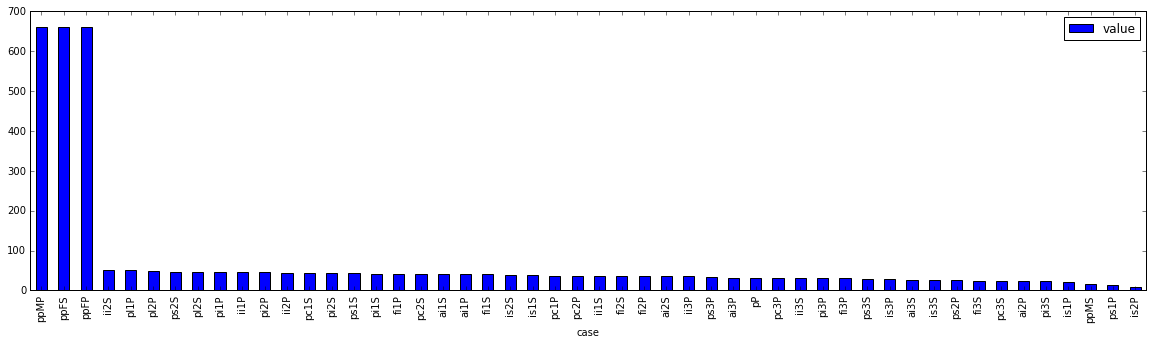

In [469]:
casesOverGeneration=overGeneration.groupby(by="case").count()[["value"]].sort_values("value",ascending=False)
casesOverGeneration.plot(kind="bar",figsize=(20,5))

In [470]:
casesOverGeneration[:3].sum()/casesOverGeneration.sum()

value    0.547764
dtype: float64

Le facteur principal de **surgénération** est la production de **participes passés** (ppMP 662, ppFS 661, ppFP 661) pour les verbes qui n'ont qu'une seule forme de participe passé invariable (ppMS) : **54.78%** (1984/3622).

### Analyse par verbes

In [480]:
overGeneration.loc[:,"verbe"]=overGeneration.index.str.rsplit("-",1).str[0]

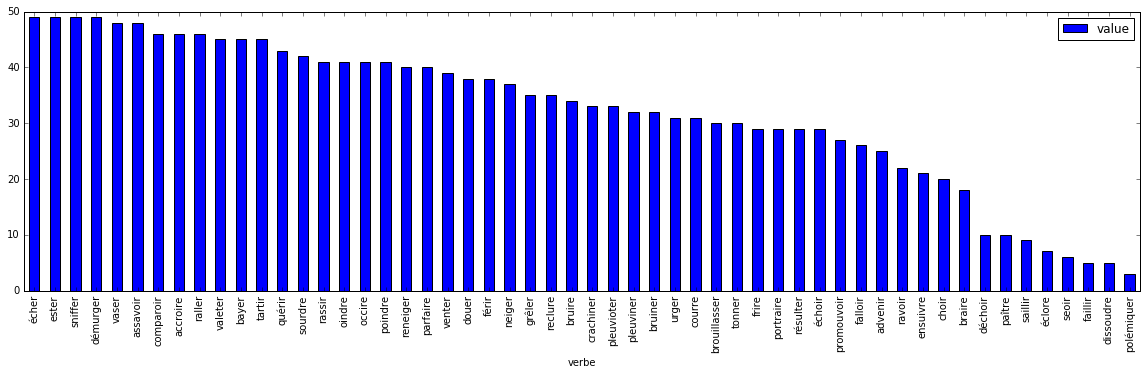

In [481]:
verbesOverGeneration=overGeneration.groupby(by="verbe").count()[["value"]].sort_values("value",ascending=False)
verbesOverGeneration[:54].plot(kind="bar",figsize=(20,5))

Le facteur principal de **surgénération** tient aux **verbes vestiges** et aux **météorologiques**.

## Analyse des sous-générations

### Analyse par cases

In [488]:
underGeneration.loc[:,"case"]=underGeneration.index.str.rsplit("-",1).str[-1]

Total sous-générations : 17126


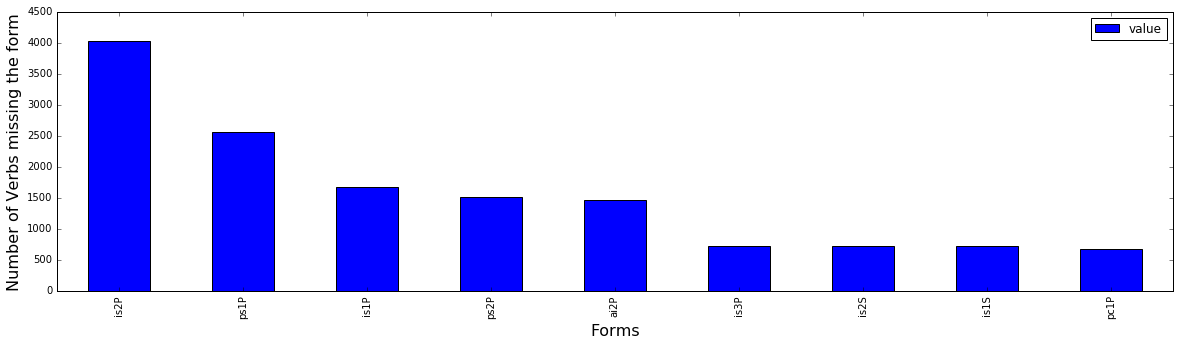

In [509]:
casesUnderGeneration=underGeneration.groupby(by="case").count()[["value"]].sort_values("value",ascending=False)
ax=casesUnderGeneration[:9].plot(kind="bar",figsize=(20,5))
ax.set_xlabel("Forms",fontsize=16)
ax.set_ylabel("Number of Verbs missing the form",fontsize=16)
print ("Total sous-générations :",casesUnderGeneration.sum().values[0])

In [515]:
def ratioAnalyses(df,chaine):
    return df[df.index.str.contains(chaine)].sum().values[0],df.sum().values[0],(df[df.index.str.contains(chaine)].sum()/df.sum()).values[0]

In [516]:
ratioAnalyses(casesUnderGeneration,"is")

(7875, 17126, 0.45982716337732105)

In [517]:
ratioAnalyses(casesUnderGeneration,"ai")

(2176, 17126, 0.12705827396940325)

In [522]:
ratioAnalyses(casesUnderGeneration,"2P")

(7897, 17126, 0.4611117598972323)

In [521]:
ratioAnalyses(casesUnderGeneration,"1P")

(5649, 17126, 0.32984935186266495)

In [528]:
ratioAnalyses(casesUnderGeneration,"pi")

(170, 17126, 0.0099264276538596295)

Le facteur principal de **sous-génération** est lié à la fréquence des TAM et de certaines personnes :
- TAM : 
 - imparfait du subjonctif 45.98% (7875/17126)
 - passé simple 12.70% (2176/17126)
- Personnes :
 - 2PL 46.11% (7897/17126)
 - 1PL 32.98% (5649/17126)


### Analyse par verbes

In [478]:
underGeneration.loc[:,"verbe"]=underGeneration.index.str.rsplit("-",1).str[0]

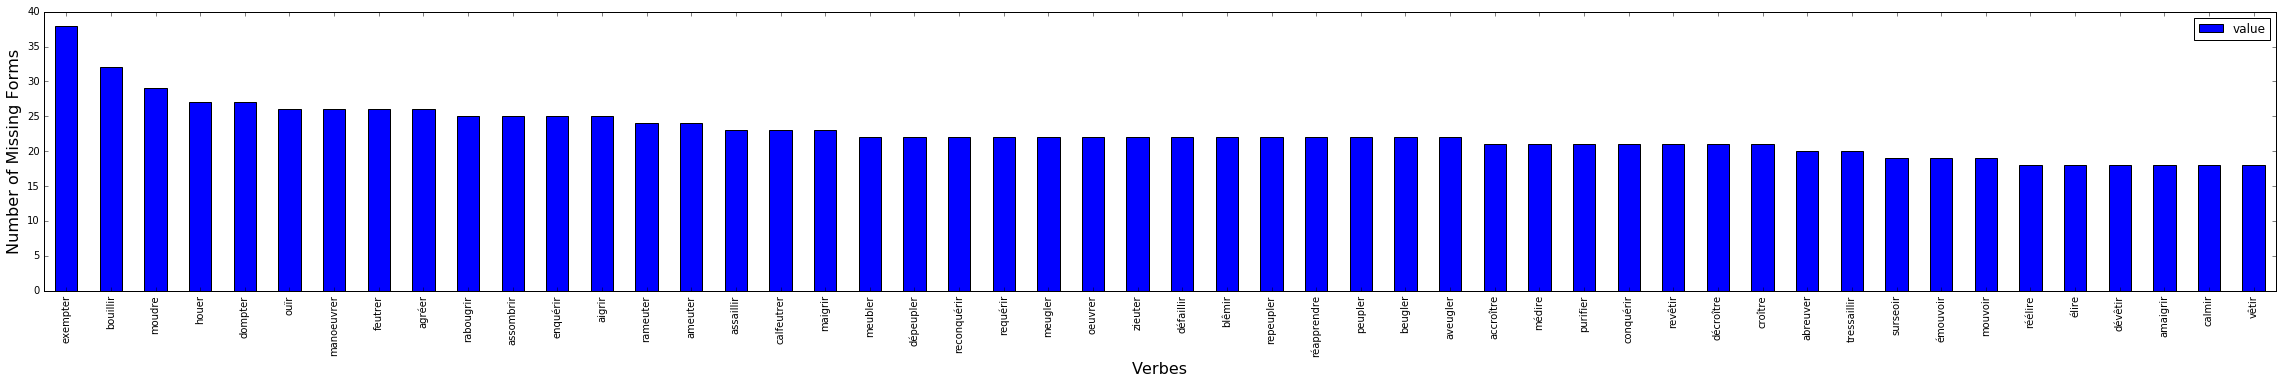

In [487]:
verbesUnderGeneration=underGeneration.groupby(by="verbe").count()[["value"]].sort_values("value",ascending=False)

ax=verbesUnderGeneration[:50].plot(kind="bar",figsize=(40,5))
ax.set_xlabel("Verbes",fontsize=16)
ax.set_ylabel("Number of Missing Forms",fontsize=16)

# Fin du traitement principal

In [ ]:
overGeneration=pd.read_csv(filepath_or_buffer=analysisPrefix+"-overGeneration.csv",encoding="utf8")
underGeneration=pd.read_csv(filepath_or_buffer=analysisPrefix+"-underGeneration.csv",encoding="utf8")
goodForms=pd.read_csv(filepath_or_buffer=analysisPrefix+"-goodForms.csv",encoding="utf8")
wrongForms=pd.read_csv(filepath_or_buffer=analysisPrefix+"-wrongForms.csv",encoding="utf8")

In [ ]:
len(overGeneration), len(underGeneration), len(goodForms), len(wrongForms)

In [ ]:
wrongForms["rightChecked"]=wrongForms["right"].apply(checkFrench)
wrongForms["valueChecked"]=wrongForms["value"].apply(checkFrench)

In [ ]:
wrongForms[wrongForms["valueChecked"]!=wrongForms["rightChecked"]]

In [ ]:
goodForms[goodForms["value"].str.contains(",")]

In [ ]:
set(overGeneration["lexeme-case"].str.rsplit("-").str[0].tolist())

In [ ]:
underGeneration["case"]=underGeneration["lexeme-case"].str.rsplit("-").str[-1]

In [ ]:
underGeneration.groupby("case").count()["value"].sort_values(ascending=False)

In [ ]:
finalParadigmes=extendParadigmes(savedContextParadigmes,extendMorphomes=True)

In [ ]:
test["ppMS"]


In [ ]:
def repairContextParadigmes(contextParadigmes):
    repaired={}
    for sCP in contextParadigmes.keys():
    #    noLexeme=False
        repaired[sCP]=[]
        for numClique,clique in enumerate(contextParadigmes[sCP]):
            repaired[sCP].append(clique)
    #        noLexemeElements=[]
    #        withLexemeElements=[]
            for numElement,element in enumerate(clique):
                if not len(element.split("-"))>2 or not element.startswith(sCP):
                    print (sCP+"-"+element)
                    repaired[sCP][numClique][numElement]=sCP+"-"+element
    #                noLexemeElements.append(element)
    #            else:
    #                withLexemeElements.append(element)
    #        if noLexemeElements:
    #            print (sCP)
    #            print (noLexemeElements)
    #            print (withLexemeElements)
    #            print ()
    #        noLexeme=False
    return repaired

In [ ]:
repairContextParadigmes(contextParadigmes)[u"féminiser"]

### Test de la sauvegarde de l'analyse brute

In [ ]:
with open(analysisPrefix+"-analyseParadigmes.pkl","rb") as input:
    savedAnalyseParadigmes = pickle.load(input)    

In [ ]:
savedContextParadigmes=savedAnalyseParadigmes[0]
savedCliques=savedAnalyseParadigmes[1]
savedCliquesScores=savedAnalyseParadigmes[2]
savedCliquesListes=savedAnalyseParadigmes[3]
#savedFormesScores=savedAnalyseParadigmes[4]
#savedFormesScoresNormes=savedAnalyseParadigmes[5]

In [ ]:
generateForms(u"crépir",contextFree=True).formes

In [ ]:
if genFormeVotes:
    fScores=(formesScores,formesScoresNormes)
    with open(analysisPrefix+paperPrefix+'-Scores.pkl', 'wb') as output:
        pickle.dump(fScores, output, pickle.HIGHEST_PROTOCOL)

In [ ]:
%%time
versionStamp=dateheure()
if genDigraphe and len(listeTest)==1: 
    nx.readwrite.write_gexf(globDigraphe,analysisPrefix+paperPrefix+u"-digraphe-%s.gexf"%versionStamp)
if genGraphe and len(listeTest)==1:
    nx.readwrite.write_gexf(globGraphe,analysisPrefix+paperPrefix+u"-graphe-%s.gexf"%versionStamp)

In [ ]:
print (len(cliques))

In [ ]:
if genCliques:
    infoCliques={"cliques":cliques, "cliquesScores":cliquesScores, "cliquesListes":cliquesListes}
    with open(analysisPrefix+paperPrefix+'-Network.pkl', 'wb') as output:
        pickle.dump(infoCliques, output, pickle.HIGHEST_PROTOCOL)

In [ ]:
print (paradigmes[paradigmes["lexeme"]==lexeme].to_latex(na_rep=""))

In [ ]:
HTML(makeTable(dictParadigmes[lexeme],title=lexeme))

In [ ]:
print (len(sampleCases),sampleCases,paradigmes["lexeme"].count())
nbCoformes=paradigmes.notnull().sum(axis=1)-1
distNbCoformes=nbCoformes.groupby(by=nbCoformes).count()
ax=distNbCoformes.plot(kind="bar",legend=False,grid=True,figsize=(10,3))
ax.set(xlim=(-0.5,32),ylim=(0,600))
ax.set_xlabel("Number of Co-Forms",fontsize=16)
ax.set_ylabel("Number of Lexemes",fontsize=16)

In [ ]:
sampleTirage[(sampleTirage["lexeme"]==u"être") & (sampleTirage["tir1"]!=0)]

In [ ]:
freqCasesSampleTirage=sampleTirage[sampleTirage["tir1"]!=0].groupby("case")[["lexeme"]].count().sort_values("lexeme",ascending=False)
ax=freqCasesSampleTirage.plot(kind="bar",legend=False,grid=True,figsize=(10,5))
ax.set(xlim=(-0.5,32.5),ylim=(0,5000))
ax.set_xlabel("Forms",fontsize=16)
ax.set_ylabel("Number of Lexemes",fontsize=16)

In [ ]:
coFormes=paradigmes.copy()
coFormes["nbCoformes"]=coFormes.notnull().sum(axis=1)-1
singletonLexemes=coFormes[coFormes["nbCoformes"]==1]["lexeme"].tolist()
print (coFormes["nbCoformes"].sum(),len(singletonLexemes))

In [ ]:
freqCaseSingleton=sampleTirage[(sampleTirage["tir1"]!=0) & (sampleTirage["lexeme"].isin(singletonLexemes))][["case","morphome"]].groupby("case").count()
ax=freqCaseSingleton.sort_values("morphome",ascending=False).plot(kind="bar",legend=False,grid=True,figsize=(8,3))
ax.set(xlim=(-0.25,17),ylim=(0,200))
ax.set_xlabel("Isolated Form",fontsize=16)
ax.set_ylabel("Number of Lexemes",fontsize=16)

In [ ]:
sampleTirage[(sampleTirage["tir1"]!=0)]["tir1"].sum()

In [ ]:
recoder("degrosirje")